In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import math
from scipy.special import softmax
import tensorflow_probability as tfp

#SEED 2 UEs
tf.random.set_seed(12)
np.random.seed(22)


In [ ]:
data = files.upload()
for f in data.keys():
    file = open(f, 'r')
    lines = file.readlines()
print(lines)

Saving VER6_PLS_DONE_PLS_ACTUAL_FINAL_SHADDD_Hmat_scenario3_15APs_Multi_3_users_FUNFINALACTUREG_complex_50000_7_28_ExtendingTesting_ver62.txt to VER6_PLS_DONE_PLS_ACTUAL_FINAL_SHADDD_Hmat_scenario3_15APs_Multi_3_users_FUNFINALACTUREG_complex_50000_7_28_ExtendingTesting_ver62 (5).txt


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
num_APs = 15
num_user = 3
pos = 0
raw_iq = []
complex_vec = []
complex_vec_total = []
count = 0
count2 = 0

for i in range(num_user):
  temp = lines[pos+i]
  temp = temp.strip()
  temp = temp.split(' ')
  raw_iq.append(temp)
  print(raw_iq[i])

for i in range(num_user):
  for jslack in raw_iq[i]:
  #i = float(i)
    if count % 2 == 0:
      tens = float(raw_iq[i][count])
    if  count % 2 == 1:
      complex_vec.append(complex(tens,float(raw_iq[i][count])))
      count2 = count2+ 1
    count = count + 1
  complex_vec_total.append(complex_vec)
  complex_vec = []
  count = 0
  count2 = 0

print(complex_vec_total[0])
print(complex_vec_total[1])


['-0.00392', '0.00551', '-0.00432', '0.00146', '-0.00185', '0.01032', '0.00005', '0.00254', '0.00242', '0.00226', '0.00089', '-0.02500', '0.00446', '0.01335', '-0.00204', '0.00945', '0.00053', '0.00062', '0.00480', '0.00700', '0.00774', '-0.01288', '0.01201', '0.00975', '-0.00065', '-0.00019', '0.00369', '-0.00470', '-0.01389', '-0.00016']
['-0.00092', '0.00294', '0.00156', '0.00279', '-0.00219', '-0.00031', '-0.00328', '0.00357', '-0.00391', '-0.00427', '0.00825', '-0.00753', '-0.00376', '-0.01277', '0.00570', '-0.00542', '-0.00343', '0.00011', '0.00535', '0.00389', '-0.00483', '-0.00048', '0.01004', '-0.00736', '-0.00330', '0.00948', '0.00109', '0.00286', '0.00822', '0.00607']
['0.00534', '-0.01761', '-0.00605', '0.00054', '0.00620', '-0.00208', '0.01124', '-0.00884', '-0.00045', '-0.00772', '0.02415', '-0.00210', '0.00277', '0.00915', '0.00616', '-0.00286', '0.00115', '-0.00764', '-0.00011', '0.00337', '-0.01955', '0.00685', '-0.00441', '-0.00377', '-0.00198', '0.00123', '0.00056', 

In [ ]:
def converttt(lines,id):  
  raw_iq = []
  complex_vec = []
  complex_vec_total = []
  count = 0
  count2 = 0

  for i in range(num_user):
    temp = lines[id+i]
    temp = temp.strip()
    temp = temp.split(' ')
    raw_iq.append(temp)
    print(raw_iq[i])

  for i in range(num_user):
    for jslack in raw_iq[i]:
    #i = float(i)
      if count % 2 == 0:
        tens = float(raw_iq[i][count])
      if  count % 2 == 1:
        complex_vec.append(complex(tens,float(raw_iq[i][count])))
        count2 = count2+ 1
      count = count + 1
    complex_vec_total.append(complex_vec)
    complex_vec = []
    count = 0
    count2 = 0

  return complex_vec_total
  #print(complex_vec_total[0])
  #print(complex_vec_total[1])


In [ ]:

freq = 1*10**6
B = 20*10**6
C = 20
S_u = 10**3
beta1 = 1
beta2 = 1 #100 for chan 1, 10 for chan 2, 1 for chan 3
p = 100 #100 #(mW)
ada_1 = 1
num_actions = num_APs
num_states = num_APs # ust passing rate
#num_states = num_APs +num_APs#state requires alphas of each AP and channel gains between each AP and the user
'''
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))
'''

lower_bound = 0
upper_bound = 1
#upper_bound = env.action_space.high[0]
#lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Max Value of Action ->  1
Min Value of Action ->  0


In [ ]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [ ]:
##orginal
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(400, activation="tanh")(inputs)  #400 
    out = layers.BatchNormalization()(out)
    out = layers.Dense(300, activation="tanh")(out)   #300   
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_APs, activation="linear", kernel_initializer=last_init)(out) #originally 1 action

    # Our upper bound is 2.0 for Pendulum.
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    #state_out = layers.Dense(16, activation="tanh")(state_input)
    #state_out = layers.Dense(32, activation="tanh")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    #action_out = layers.Dense(32, activation="tanh")(action_input)

    # Both are passed through seperate layer before concatenating
    #concat = layers.Concatenate()([state_out, action_out])
    concat = layers.Concatenate()([state_input, action_input])
    ############################ new
    out = layers.BatchNormalization()(concat)    
    out = layers.Dense(400, activation="tanh")(out)  #400  
    ##############################

    #######out = layers.Dense(256, activation="tanh")(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(300, activation="tanh")(out)  #300  
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_APs,activation="linear")(out)  #originally sigmoid
    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    
    return model


In [ ]:
##orginal  alpha = 0.1 originally used in all networks
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256)(inputs)
    out = layers.LeakyReLU(alpha=0.1)(out)   #all were alpha = 0.1 and 256 neurons
    out = layers.BatchNormalization()(out)
    out = layers.Dense(128)(out)
    out = layers.LeakyReLU(alpha=0.1)(out)
    out = layers.BatchNormalization()(out)

    '''
    out = layers.Dense(256, activation="tanh")(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="tanh")(out)
    out = layers.BatchNormalization()(out)
    '''
    outputs = layers.Dense(num_APs, activation="tanh", kernel_initializer=last_init)(out) #originally 1 action linear

    # Our upper bound is 2.0 for Pendulum.
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    #state_out = layers.Dense(16, activation="tanh")(state_input)
    #state_out = layers.Dense(32, activation="tanh")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    #action_out = layers.Dense(32, activation="tanh")(action_input)

    # Both are passed through seperate layer before concatenating
    #concat = layers.Concatenate()([state_out, action_out])
    concat = layers.Concatenate()([state_input, action_input])
    ############################ new
    out = layers.BatchNormalization()(concat)    
    out = layers.Dense(256)(out)
    out = layers.LeakyReLU(alpha=0.1)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(128)(out)  
    out = layers.LeakyReLU(alpha=0.1)(out)
    out = layers.BatchNormalization()(out)



    '''
    out = layers.Dense(256, activation="tanh")(out)
    ##############################

    #######out = layers.Dense(256, activation="tanh")(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="tanh")(out)
    out = layers.BatchNormalization()(out)
    '''
    outputs = layers.Dense(num_APs,activation="tanh")(out)  #originally sigmoid/linear
  
    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    
    return model


In [ ]:

def policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    #print('NN output')
    #print(sampled_actions.numpy()) #debug
    temp = sampled_actions
    ###########print('TEMP')
    ##########print(sampled_actions)
    #noise = noise_object()
    #temp2 = noise
    # Adding noise to action
    '''
    sampled_actions = sampled_actions.numpy() + noise
    
   
     
    # We make sure action is within bounds
    
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    legal_action = legal_action/np.sum(legal_action) 

    '''
    
    
    legal_action = sampled_actions.numpy()#/np.sum(sampled_actions.numpy()) 
    for val in range(num_APs):
      if legal_action[val] < 0:
        legal_action[val] = 0#legal_action[val]*-1

    #re-normalize
    legal_action = legal_action/np.sum(legal_action) 
  


    #legal_action = softmax(legal_action)
    
    '''
    valll = np.max(legal_action)
    idddd = np.argmax(legal_action)
    update_val = np.random.uniform(0,valll)
    '''
    
   
    #strategy 1
    '''
    inttt_rand = np.random.randint(0,num_APs)
    legal_action[idddd] = legal_action[idddd] - update_val
    legal_action[inttt_rand] = legal_action[inttt_rand] + update_val
    '''

    #strategy 2
    '''
    legal_action[idddd] = legal_action[idddd] - update_val
    for_others_update_val = (update_val)/(num_APs-1)
    listttt = list(range(0,num_APs))
    listttt.pop(idddd)
    for jjj in listttt:
      legal_action[jjj] = legal_action[jjj] + for_others_update_val
    '''
    
 
    #strategy 3
    '''
    percentagesss = np.random.uniform(0,1,num_APs-1)
    percentagesss = percentagesss/np.sum(percentagesss)
    legal_action[idddd] = legal_action[idddd] - update_val
    percentagesss = percentagesss * update_val
    listttt = list(range(0,num_APs))
    listttt.pop(idddd)
    count = 0
    for jjj in listttt:
      if jjj ==  num_APs-1:
        legal_action[jjj] = legal_action[jjj] + percentagesss[idddd]
      else:
        legal_action[jjj] = legal_action[jjj] + percentagesss[jjj]
    '''
    
    
    
    



  


    '''
    legal_action = sampled_actions/np.sum(sampled_actions) 
    noisssse = np.random.rand(1,10)
    legal_action = legal_action + noisssse - np.mean(noisssse)
    '''
    
    
    ################legal_action = legal_action/np.sum(legal_action)

    ####THIS WORKS!!!
    #legal_action = sampled_actions.numpy()/np.sum(sampled_actions.numpy()) 
    

    

    return [np.squeeze(legal_action)]
    

  




In [ ]:

def policy_testing(state):
    sampled_actions = tf.squeeze(actor_model(state))
    #######print('NN output')
    #########print(sampled_actions.numpy()) #debug
    #temp = sampled_actions
    #print('TEMP')
    #print(sampled_actions)
    epsilonn = 10**-6
    #temp2 = noise
    # Adding noise to action
    '''
    sampled_actions = sampled_actions.numpy() + noise
    
   
     
    # We make sure action is within bounds
    
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    legal_action = legal_action/np.sum(legal_action) 

    '''


    '''
    for val in range(num_APs):
      if sampled_actions[val] < 0:
        sampled_actions[val] = sampled_actions[val]*-1

   # legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    legal_action = sampled_actions/np.sum(sampled_actions) 
    noisssse = np.random.rand(1,10)
    legal_action = legal_action + noisssse - np.mean(noisssse)
    '''

    legal_action = sampled_actions.numpy()#/np.sum(sampled_actions.numpy())

    for val in range(num_APs):
      if legal_action[val] < 0:
        legal_action[val] = 0#legal_action[val]*-1

    #re-normalize
    legal_action = legal_action/np.sum(legal_action) 


  
    #legal_action = softmax(legal_action)
    #################################legal_action = softmax(sampled_actions.numpy()) 
    #legal_action = np.exp(legal_action) + epsilonn
    #legal_action = np.random.dirichlet(legal_action) 

 
    '''
    HOWHTISWORK
    legal_action = np.random.dirichlet(legal_action)
    legal_action = np.exp(legal_action) + epsilonn
    '''
     

    #legal_action = np.log2(legal_action)
    #legal_action = legal_action/sum(legal_action)



    #legal_action = legal_action + noise #new new
    
    

 
    ###############legal_action = legal_action/np.sum(legal_action) 
    
    
    #legal_action = softmax(sampled_actions.numpy()+noise) #could try with random instead?
    #legal_action = sampled_actions

    '''
    afl = sampled_actions#+noise
    afl = np.clip(afl, lower_bound, upper_bound)

    legal_action = softmax(afl) #could try with random instead?
    '''

    return [np.squeeze(legal_action)]
    

  




In [ ]:
std_dev = 0.2
#ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))  
#ou_noise = OUActionNoise(mean=np.zeros(num_APs), std_deviation=float(std_dev) * np.ones(num_APs))  

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
#These worked!!!
#####critic_lr = 0.02   
#####actor_lr = 0.001     

#tanh tanh linear
critic_lr = 0.2  #0.02 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.0001 #0.001 - 2 users  0.0001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr) #adam
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)  #adam

total_episodes = 300 #300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.0001 #0.0001

buffer = Buffer(200, 128) #200,64 32 64 - 2 users was working!!!                50000  #200 -2:55, 64  128 works 10000 256  32 gave nans 512

In [ ]:
# To store reward history of each episode
ep_reward_list = []
solo1 = []
solo2 = []
# To store average reward history of last few episodes
const_reward_list = []
unif_reward_list = []
new_reward = 0
best_alphas = np.zeros(shape=(1,num_APs))
#best_alphas = np.zeros(shape=(1,10))
b1  = 0
indexxx = 0

# Takes about 4 min to train
for ep in range(total_episodes):

    #prev_state = env.reset() ep*1000
    prev_state = np.zeros([num_states,])
    episodic_reward = 0
    alphasss = []
    for i in range(num_user):
      rand_vecs = np.random.random(size=(1,num_APs))
      rand_vecs = rand_vecs/np.sum(rand_vecs)
      alphasss.append(rand_vecs[0])
    
    indexxx = ep*200
    #indexxx = ep*1000
    #print('Step')
    #print(indexxx)
    #print(200+ep*200)
    '''
    comp, fla = converttt(lines,0)
    prev_state[0:10] = fla
    prev_state[10:21] = alphasss
    '''

    #while indexxx < len(lines)-1:
    #while indexxx < 1000 + ep*1000:
    while indexxx < 200 + ep*200:
    #while indexxx < 15:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        #print(prev_state)
        #prev_state = np.asarray(prev_state).astype(np.float32)
        ############print(indexxx)   
        tf_prev_state = [[]]*num_user
        if indexxx > 0:
          print('Step')
          print(indexxx)
          for jwiw in range(num_user):
            tf_prev_state[jwiw] = (tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0))
        else:
          for jwiw in range(num_user):
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0)

      
        actions = []
        #if indexxx == ep*1000: #1000: #0: 200
        if indexxx == ep*200:
          for ikea in range(num_user):
            actions.append(np.asarray(alphasss[ikea]))
        else:
          for ikea22 in range(num_user):
            actions.append(policy(tf_prev_state[ikea22])[0])
            #actions.append(policy(tf_prev_state[ikea22], ou_noise)[0])
          #action = softmax(tf_prev_state)
          ######action = action[0]
          
          #TO EXPERIMENT COMMENTING THIS OUT
          '''
          while 0 in action:
            action = policy(tf_prev_state, ou_noise)
            #action = softmax(tf_prev_state)
            action = action[0]
          '''
          
        latencies_co = []
        latencies_u_co = []
        latencies_b_co = []
        sum_temp = np.zeros(shape=(1,num_APs))
        sum_den = np.zeros(shape=(1,num_APs))
        sum_temp_u = np.zeros(shape=(1,num_APs))
        sum_den_u = np.zeros(shape=(1,num_APs))
        sum_temp_b = []
        sum_den_b = []
        for swag in range(num_user):
          action = actions[swag]
    
          alphasss = action
          ########################product = alphasss*S_u
          oneminussquared = (1-alphasss)**2
          squareddd = alphasss**2
          chan_squared = (np.absolute(complex_vec_total[swag])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ###########################den = 1+ ((p*ada_1)*(oneminussquared*chan_squared))
          den = ((p*ada_1)*(oneminussquared*chan_squared))

          temp = (((p*ada_1)*(squareddd*chan_squared)))
          ############################rate = ((B*np.log2((1+(((p*ada_1)*(squareddd*chan_squared))/den)))))


          sum_den[0] = sum_den[0] + den
          sum_temp[0] = sum_temp[0] + temp



          # should do this if somehow channel becomes zero (i.e. shadow)
        
        rate = ((B*np.log2((1+((sum_temp)/(1+sum_den))))))

        un_dB_sinr = ((sum_temp)/(1+sum_den))
        '''
        if indexxx > 0:
          print('Original')
          print(rate)
        '''
        #### CHecking ###
        for sew in range(num_user):
        
          alphasss_indices = np.where(actions[sew]==0)[0]
          print('Alphas Indices')
          print(alphasss_indices)

          new_rate = rate[0].copy()

          
          for i in alphasss_indices:  #setting rates where alpha = 0 to zero
            new_rate[i] = 0 
 
          print('Alphasss')
          print(actions[sew])
          new_alphasss = actions[sew][actions[sew] != 0]

          
          observing_rate_indices = np.where(new_rate==0)[0]
          observing_alphasss_indices = np.where(actions[sew]==0)[0]
          tezerk = len(observing_rate_indices)
          tezerk2 = len(observing_alphasss_indices)

          if tezerk != tezerk2:
            print('Size Damn it')
            print('chan squared')
            print(chan_squared)
            print('Alphas')
            print(alphasss)
            print('Temp')
            print(temp)
            print('Den')
            print(den)
            print('Rate')
            print(rate[0])
            print('New Rate')
            print(new_rate)
            quit()

          for excak in range(tezerk):
            if observing_rate_indices[excak] != observing_alphasss_indices[excak]:
              print('Damn it')
              print(chan_squared)
              print('Alphas')
              print(alphasss)
              print('Temp')
              print(temp)
              print('Den')
              print(den)
              print('Rate')
              print(rate[0])
              print('New Rate')
              print(new_rate)
              quit()
          



          ##TODO: FOR THE ALPHAS THAT ARE ZERO REMOVE THE CORRESPONDING INDICES FROM THE RATE EVEN IF NOT ZERO INSTEAD OF SEEING IF THEY MATCH
          new_rate = new_rate[new_rate != 0]
          product = actions[sew]*S_u

          product = product[product!=0]

        
      

  

          #un_dB_sinr = (2**(new_rate/B)) - 1


        ###################################un_dB_sinr = ((((p*ada_1)*(squareddd*chan_squared))/den))




      # Recieve state and reward from environment.
      #state, reward, done, info = env.step(action)
          
          total_latency = (beta1*(new_alphasss*S_u*C)/freq) + (beta2*(product/new_rate))
          latencies_co.append(total_latency)
         
        final_rewards = []
        for fight in range(num_user):
          final_rewards.append(np.max(latencies_co[fight]))

        #xx1 = np.max(latencies_co[0])
        #xx2 = np.max(latencies_co[1])
        #reward =np.mean([xx1, xx2]) 
        '''
        if indexxx == ep*200:
          reward =np.mean([xx1, xx2]) 
          old_reward = reward
        else:
          reward =np.mean([xx1, xx2]) 
          reward = reward - old_reward
          old_reward = reward
        '''
          
        reward = np.max(final_rewards)
        #reward = np.max([xx1, xx2]) 
        #reward =np.sum([xx1, xx2]) 

        #####Trying this out - 6PM
        #final_rewards = []
        #final_rewards.append(-1*xx1)
        #final_rewards.append(-1*xx2)
        #solo1.append(xx1)
        #solo2.append(xx2)

        reward= -1*reward

      



        # End this episode when `done` is True
        #if done:
        #    break

        #prev_state = state
        #ep_reward_list.append(episodic_reward)
 
        ##### UNIFORM
        for delicious in range(num_user):
          unif_alphasss = 1/num_APs*np.ones([1,num_APs]) 
          #unif_alphasss = 1/10*np.ones([1,10]) 
          product_u = unif_alphasss*S_u
          oneminussquared_u = (1-unif_alphasss)**2
          squareddd_u = unif_alphasss**2
          chan_squared_u = (np.absolute(complex_vec_total[delicious])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ########################den_u = 1+ ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          den_u = ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          temp_u = (((p*ada_1)*(squareddd_u*chan_squared_u)))


          sum_den_u[0] = sum_den_u[0] + den_u
          sum_temp_u[0] = sum_temp_u[0] + temp_u

          #########rate_u = ((B*np.log2((1+(((p*ada_1)*(squareddd_u*chan_squared_u))/den_u)))))

          
        rate_u = ((B*np.log2((1+((sum_temp_u)/(1+sum_den_u))))))   
        total_latency_u = (beta1*(unif_alphasss*S_u*C)/freq) + (beta2*(product_u/rate_u))
        #because alphas are always uniform for both users, can just multiply reward by 2. 

        reward_u = np.max(total_latency_u[0])   #2*
        '''
        if indexxx == ep*200:
          reward_u = np.max(total_latency_u[0])  
          old_reward_u = reward_u
        else:
          reward_u = np.max(total_latency_u[0])   
          reward_u = reward_u - old_reward_u
          old_reward_u = reward_u
        '''
          



        '''
        latencies_u_co.append(total_latency_u[0])
        xx1_u = np.max(latencies_u_co[0])
        xx2_u = np.max(latencies_u_co[1])
        reward_u =np.sum([xx1_u, xx2_u]) 
       '''
        
 
        
        unif_reward_list.append(reward_u)

        best_channel_gains = []
        #### BEST Method
        for great in range(num_user):
          best_id = np.argmax(np.abs(complex_vec_total)[great])
          best_channel_gains.append(best_id)
          best_alphasss = 1

          product_b = best_alphasss*S_u
          oneminussquared_b = (1-best_alphasss)**2
          squareddd_b = best_alphasss**2

          chan_squared_b = (np.absolute(complex_vec_total[great][best_id])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          #####################den_b = 1+ ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          den_b = ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          temp_b = (((p*ada_1)*(squareddd_b*chan_squared_b)))
          sum_den_b.append(den_b)
          sum_temp_b.append(temp_b)
          #####################rate_b = ((B*np.log2((1+(((p*ada_1)*(squareddd_b*chan_squared_b))/den_b)))))
        
        duplicates = []
        for j in best_channel_gains:
          if j in duplicates:
            continue
          else:
            timeagain = np.argwhere(best_channel_gains == j)[0]
            #if more than 1 sum up the indices
            temp_sum_den_b = 0
            temp_sum_temp_b = 0
          for iterating in timeagain:
            temp_sum_den_b = temp_sum_den_b + sum_den_b[iterating]
            temp_sum_temp_b = temp_sum_temp_b + sum_temp_b[iterating]
          
          rate_b = ((B*np.log2((1+((temp_sum_temp_b)/(1+temp_sum_den_b))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          latencies_b_co.append(total_latency_b)
          #delete from best_gains
          duplicates.append(timeagain[0])


        '''
        if best_channel_gains[0] == best_channel_gains[1]: # if same AP is chosen for both add them together. 
          sum_den_bb = np.sum(sum_den_b)
          sum_temp_bb = np.sum(sum_temp_b) #need to add for same alpha
          rate_b = ((B*np.log2((1+((sum_temp_bb)/(1+sum_den_bb))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          reward_b = total_latency_b #because now doing  for same alpha #2*total_latency_b #because same alpha
        else:  # if not they are sepearte entities
          for i in range(len(sum_den_b)):
            rate_b = ((B*np.log2((1+((sum_temp_b[i])/(1+sum_den_b[i]))))))
            total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
            latencies_b_co.append(total_latency_b)
          
          xx1_b = np.max(latencies_b_co[0])
          xx2_b = np.max(latencies_b_co[1])
          #reward_b =np.mean([xx1_b, xx2_b]) 
          reward_b = np.max([xx1_b, xx2_b]) 
          #reward_b =np.sum([xx1_b, xx2_b]) 
        '''
        reward_b = np.max(latencies_b_co)

        '''
        if indexxx == ep*200: 
          old_reward_b = reward_b
        else:
          reward_b = reward_b - old_reward_b
          old_reward_b = reward_b
        '''
        
      

     
        const_reward_list.append(reward_b)
        
        indexxx = indexxx + num_user#2#1
        if indexxx < len(lines):
          complex_vec_total = converttt(lines,indexxx)
          state = []
          for iii in range(num_user):
            status =  np.empty((1, num_states), dtype=np.object)  #TODO: how to assign to None,30 or convert 1,1,30 to None,3
            for jwe in range(num_states):
              #status[0][jwe] = np.log2(np.absolute(complex_vec_total[iii][jwe]))
              #status[0][jwe] = un_dB_sinr[0][jwe]
              status[0][jwe] = (un_dB_sinr[0][jwe])

              '''
              if jwe < num_APs:
                status[0][jwe] = un_dB_sinr[0][jwe]
              else:
                status[0][jwe] = np.log2(np.absolute(complex_vec_total[iii][jwe-10]))
              '''
            
            status= status[0].astype('float64')
              #############state[0][iii] = (un_dB_sinr[0][iii])
            state.append(status)
            
           
          
          #state = state[0].astype('float64')
        else:
          print('Stop')
          break
        
        
        
        #print('State')
        #print(state)
        #print('Alphasss')
        #print(actions)
        print('Reward')
        print(reward*-1)
        
        
        



        '''
        print('Computational latency')
        print((beta1*(alphasss*S_u*C)/freq)) 
        print('Transmission Latency')
        print(beta2*(product/rate))
        '''
        
        
        for ew in range(num_user):
           buffer.record((prev_state[ew], actions[ew], reward, state[ew])) #dont know if this should be -reward or not
           #############buffer.record((prev_state[ew], action[ew], final_rewards[ew], state[ew])) #dont know if this should be -reward or not


        ############buffer.record((prev_state, alphasss, reward, state)) #dont know if this should be -reward or not
        episodic_reward = (reward*-1)

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        #indexxx = indexxx + 1
        prev_state = state
        ep_reward_list.append(episodic_reward)

        

    #ep_reward_list.append(episodic_reward)
    

    ## Mean of last 40 episodes
    ##avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    #vg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
print(indexxx)
#count = b1/float(1000)
#print(count)

Alphas Indices
[]
Alphasss
[0.03068536 0.07090338 0.06190314 0.12647146 0.02519496 0.04988072
 0.03982239 0.10172118 0.03244351 0.11951905 0.00154955 0.0826091
 0.11978037 0.10967865 0.02783716]
Alphas Indices
[]
Alphasss
[0.00068746 0.08642929 0.10722804 0.07858101 0.03331349 0.08597577
 0.07704513 0.04334468 0.06887147 0.04786424 0.06541045 0.07865911
 0.01252652 0.10335884 0.1107045 ]
Alphas Indices
[]
Alphasss
[0.11537359 0.13542893 0.00495215 0.03027514 0.14901381 0.12687352
 0.08653566 0.02185726 0.08248114 0.08784425 0.05301322 0.00777687
 0.07454383 0.01633064 0.00769999]
['0.00179', '0.00830', '-0.00677', '-0.00042', '0.00301', '0.00378', '0.01900', '0.00833', '-0.00126', '0.00025', '-0.00646', '0.01698', '0.00947', '-0.01321', '0.03606', '0.02272', '0.00053', '-0.00199', '0.00771', '-0.00431', '0.00199', '-0.00043', '0.00025', '0.00781', '0.01478', '0.00159', '-0.00077', '0.00686', '0.00198', '0.01567']
['0.00499', '-0.00067', '-0.00868', '0.00286', '-0.00735', '0.00057', '0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:373: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
Alphasss
[0.07361875 0.         0.12901166 0.         0.12837373 0.1216922
 0.12314256 0.         0.         0.00301803 0.06987511 0.07753879
 0.16565986 0.         0.10806934]
Alphas Indices
[ 1  3  7  8 13]
Alphasss
[0.07361875 0.         0.12901166 0.         0.12837373 0.1216922
 0.12314256 0.         0.         0.00301803 0.06987511 0.07753879
 0.16565986 0.         0.10806934]
Alphas Indices
[ 1  3  7  8 13]
Alphasss
[0.07361875 0.         0.12901166 0.         0.12837373 0.1216922
 0.12314256 0.         0.         0.00301803 0.06987511 0.07753879
 0.16565986 0.         0.10806934]
['0.01262', '0.01601', '-0.00739', '-0.00694', '-0.01007', '-0.01486', '0.00767', '-0.05578', '0.00865', '0.09407', '-0.06863', '-0.01560', '0.01727', '0.01295', '-0.00175', '0.00136', '-0.00633', '0.00530', '-0.00263', '0.02083', '-0.00562', '0.00128', '0.01125', '-0.00016', '0.01615', '0.00329', '-0.00796', '0.00010', '-0.01598', '-0.00766']
['-0.004

In [ ]:
print(len(oneminussquared))
print(len(oneminussquared))
#print(iterating[0])
#print(sum_den_b[0])
#print(best_channel_gains)
#print(best_channel_gains[best_channel_gains!=0])
#print(observing_rate_indices)
#print(observing_alphasss_indices)
'''
print(sum_den_u)
print(sum_temp_u)
print(((B*np.log2((1+((sum_temp_u)/(1+sum_den_u)))))))

print(alphasss_indices)
print(actions[sew]) 
print(alphasss)
print(rate[0])
print(new_rate)
'''

20


'\nprint(sum_den_u)\nprint(sum_temp_u)\nprint(((B*np.log2((1+((sum_temp_u)/(1+sum_den_u)))))))\n\nprint(alphasss_indices)\nprint(actions[sew]) \nprint(alphasss)\nprint(rate[0])\nprint(new_rate)\n'

In [ ]:
print(total_latency)
print(total_latency_u)
print(total_latency_b)


[ 186.91558017   25.01427168   29.64307492   27.78037481   32.91000733
   79.307628     28.94238158 1186.59700406   35.60432172  434.07528692]
[[20.82849415 21.41018655 23.40284172 25.71822535 31.90781301 58.66525036
  36.55811032 30.18175987 42.5893708  39.24056754]]
200.07051874793837


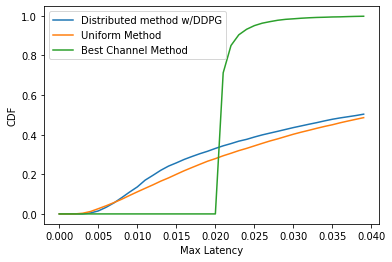

In [ ]:
stats = np.arange(0,0.04,0.001)
#stats = np.arange(10, 5000, 10)
#stats = np.arange(2, 250, 2)
ep_cdf =np.zeros([1,len(stats)])[0]
unif_cdf =np.zeros([1,len(stats)])[0]
const_cdf =np.zeros([1,len(stats)])[0]
#solo1_cdf =np.zeros([1,len(stats)])[0]
#solo2_cdf =np.zeros([1,len(stats)])[0]
count = 0
for il in stats:
  #print('index ' + str(il))
  tata = len(np.argwhere(ep_reward_list<il))
  #print('count ' + str(tata))
  tata2 = len(np.argwhere(unif_reward_list<il))
  tata3 = len(np.argwhere(const_reward_list<il))
  tata4 = len(np.argwhere(solo1<il))
  tata5 = len(np.argwhere(solo2<il))
  ep_cdf[count] = tata/((200+ep*200)/num_user) #(1000+ep*1000)  (200+ep*200)
  unif_cdf[count] = tata2/((200+ep*200)/num_user)
  const_cdf[count] = tata3/((200+ep*200)/num_user)
  #solo1_cdf[count] = tata4/((200+ep*200)/2)
  #solo2_cdf[count] = tata4/((200+ep*200)/2)
  count = count + 1


plt.plot(stats,ep_cdf)
plt.plot(stats,unif_cdf)
plt.plot(stats,const_cdf)
#plt.plot(solo1_cdf)
#plt.plot(solo2_cdf)
plt.xlabel("Max Latency")
plt.ylabel("CDF")
plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()

In [ ]:
print(8239/((200+ep*200)/num_user))


0.8239


In [ ]:
# Save the weights
actor_model.save_weights("sam260.h5")
#critic_model.save_weights("cell_critic.h5")

#target_actor.save_weights("cell_target_actor.h5")
#target_critic.save_weights("cell_target_critic.h5")

In [ ]:
#getting new channel state info
data222 = files.upload()
for f in data222.keys():
    file = open(f, 'r')
    testlines = file.readlines()
print(testlines)

Saving VER6_PLS_DONE_PLS_ACTUAL_FINAL_SHADDD_Hmat_scenario3_15APs_Multi_3_users_FUNFINALACTUREG_complex_part2_7_28_ExtendingTesting_ver62.txt to VER6_PLS_DONE_PLS_ACTUAL_FINAL_SHADDD_Hmat_scenario3_15APs_Multi_3_users_FUNFINALACTUREG_complex_part2_7_28_ExtendingTesting_ver62 (3).txt
['-0.01273 -0.01515 -0.01997 -0.00848 0.01877 0.02467 0.00893 -0.00093 -0.00195 0.00680 0.02008 0.00193 0.01061 -0.01914 0.01729 0.00232 0.01569 0.02321 -0.01871 -0.02082 0.01026 -0.01466 0.00409 -0.00157 -0.00403 0.00036 -0.00894 0.00191 -0.00068 0.00129\n', '0.00634 0.00101 0.00326 -0.00050 -0.00202 -0.00474 0.00300 -0.00496 0.01526 0.00421 -0.00092 -0.00736 0.00061 -0.01937 0.00340 0.00166 0.00039 0.00316 0.00215 -0.01166 0.01026 -0.01466 0.00409 -0.00157 -0.00403 0.00036 -0.00894 0.00191 -0.00068 0.00129\n', '0.04459 -0.05112 0.02284 0.03419 -0.01496 -0.03720 0.00665 0.01438 0.00063 -0.02040 -0.00553 0.00523 0.01320 -0.00592 0.00979 -0.00861 0.00135 -0.00678 0.00326 0.00245 0.01026 -0.01466 0.00409 -0.0

In [ ]:
pos = 0
raw_iq = []
complex_vec2 = []
complex_vec_total_p2 = []
count = 0
count2 = 0

for i in range(num_user):
  temp = testlines[pos+i]
  temp = temp.strip()
  temp = temp.split(' ')
  raw_iq.append(temp)
  print(raw_iq[i])

for i in range(num_user):
  for jslack in raw_iq[i]:
  #i = float(i)
    if count % 2 == 0:
      tens = float(raw_iq[i][count])
    if  count % 2 == 1:
      complex_vec2.append(complex(tens,float(raw_iq[i][count])))
      count2 = count2+ 1
    count = count + 1
  complex_vec_total_p2.append(complex_vec2)
  complex_vec2 = []
  count = 0
  count2 = 0

print(complex_vec_total_p2[0])
print(complex_vec_total_p2[1])



['-0.01273', '-0.01515', '-0.01997', '-0.00848', '0.01877', '0.02467', '0.00893', '-0.00093', '-0.00195', '0.00680', '0.02008', '0.00193', '0.01061', '-0.01914', '0.01729', '0.00232', '0.01569', '0.02321', '-0.01871', '-0.02082', '0.01026', '-0.01466', '0.00409', '-0.00157', '-0.00403', '0.00036', '-0.00894', '0.00191', '-0.00068', '0.00129']
['0.00634', '0.00101', '0.00326', '-0.00050', '-0.00202', '-0.00474', '0.00300', '-0.00496', '0.01526', '0.00421', '-0.00092', '-0.00736', '0.00061', '-0.01937', '0.00340', '0.00166', '0.00039', '0.00316', '0.00215', '-0.01166', '0.01026', '-0.01466', '0.00409', '-0.00157', '-0.00403', '0.00036', '-0.00894', '0.00191', '-0.00068', '0.00129']
['0.04459', '-0.05112', '0.02284', '0.03419', '-0.01496', '-0.03720', '0.00665', '0.01438', '0.00063', '-0.02040', '-0.00553', '0.00523', '0.01320', '-0.00592', '0.00979', '-0.00861', '0.00135', '-0.00678', '0.00326', '0.00245', '0.01026', '-0.01466', '0.00409', '-0.00157', '-0.00403', '0.00036', '-0.00894', '

In [ ]:
#load weights -- need to understand what's needed here during testing phase
actor_model.load_weights("sam260.h5")


# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
const_reward_list = []
unif_reward_list = []
new_reward = 0
best_alphas = np.zeros(shape=(1,num_APs))
#best_alphas = np.zeros(shape=(1,10))
b1  = 0
indexxx = 0
total_episodes = 1
# Takes about 4 min to train
for ep in range(total_episodes):

    #prev_state = env.reset() ep*1000
    prev_state = np.zeros([num_states,])
    episodic_reward = 0
    alphasss = []
    for i in range(num_user):
      rand_vecs = np.random.random(size=(1,num_APs))
      rand_vecs = rand_vecs/np.sum(rand_vecs)
      alphasss.append(rand_vecs[0])
    
    #indexxx = ep*1000
    #print('Step')
    #print(indexxx)
    #print(200+ep*200)
    '''
    comp, fla = converttt(lines,0)
    prev_state[0:10] = fla
    prev_state[10:21] = alphasss
    '''

    #while indexxx < len(testlines)-1:
    while indexxx < len(testlines)-(num_user-1):
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        #print(prev_state)
        #prev_state = np.asarray(prev_state).astype(np.float32)  
        tf_prev_state = [[]]*num_user
        if indexxx > 0:
          for jwiw in range(num_user):
            tf_prev_state[jwiw] = (tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0))
        else:
          for jwiw in range(num_user):
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0)

      
        actions = []
        
        if indexxx == 0:
          for ikea in range(num_user):
            actions.append(np.asarray(alphasss[ikea]))
        else:
          for ikea22 in range(num_user):
            actions.append(policy_testing(tf_prev_state[ikea22])[0])
          #action = softmax(tf_prev_state)
          ######action = action[0]
          
          #TO EXPERIMENT COMMENTING THIS OUT
          '''
          while 0 in action:
            action = policy(tf_prev_state, ou_noise)
            #action = softmax(tf_prev_state)
            action = action[0]
          '''
          
        latencies_co = []
        latencies_u_co = []
        latencies_b_co = []
        sum_temp = np.zeros(shape=(1,num_APs))
        sum_den = np.zeros(shape=(1,num_APs))
        sum_temp_u = np.zeros(shape=(1,num_APs))
        sum_den_u = np.zeros(shape=(1,num_APs))
        sum_temp_b = []
        sum_den_b = []
        for swag in range(num_user):
          action = actions[swag]
    
          alphasss = action
          ########################product = alphasss*S_u
          oneminussquared = (1-alphasss)**2
          squareddd = alphasss**2
          chan_squared = (np.absolute(complex_vec_total_p2[swag])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ###########################den = 1+ ((p*ada_1)*(oneminussquared*chan_squared))
          den = ((p*ada_1)*(oneminussquared*chan_squared))





          temp = (((p*ada_1)*(squareddd*chan_squared)))
          ############################rate = ((B*np.log2((1+(((p*ada_1)*(squareddd*chan_squared))/den)))))


          sum_den[0] = sum_den[0] + den
          sum_temp[0] = sum_temp[0] + temp



          # should do this if somehow channel becomes zero (i.e. shadow)
        
        rate = ((B*np.log2((1+((sum_temp)/(1+sum_den))))))


        un_dB_sinr = ((sum_temp)/(1+sum_den))
        '''
        if indexxx > 0:
          print('Original')
          print(rate)
        '''
        #### CHecking ###
        
        for sew in range(num_user):
        
          alphasss_indices = np.where(actions[sew]==0)[0]
          print('Alphas Indices')
          print(alphasss_indices)


          new_rate = rate[0].copy()

          
          for i in alphasss_indices:  #setting rates where alpha = 0 to zero
            new_rate[i] = 0 

          print('Alphasss')
          print(actions[sew])
          new_alphasss = actions[sew][actions[sew] != 0]

          
          observing_rate_indices = np.where(new_rate==0)[0]
          observing_alphasss_indices = np.where(actions[sew]==0)[0]
          tezerk = len(observing_rate_indices)
          tezerk2 = len(observing_alphasss_indices)

          if tezerk != tezerk2:
            print('Size Damn it')
            print('chan squared')
            print(chan_squared)
            print('Alphas')
            print(alphasss)
            print('Temp')
            print(temp)
            print('Den')
            print(den)
            print('Rate')
            print(rate[0])
            print('New Rate')
            print(new_rate)
            quit()

          for excak in range(tezerk):
            if observing_rate_indices[excak] != observing_alphasss_indices[excak]:
              print('Damn it')
              print(chan_squared)
              print('Alphas')
              print(alphasss)
              print('Temp')
              print(temp)
              print('Den')
              print(den)
              print('Rate')
              print(rate[0])
              print('New Rate')
              print(new_rate)
              quit()
          



          ##TODO: FOR THE ALPHAS THAT ARE ZERO REMOVE THE CORRESPONDING INDICES FROM THE RATE EVEN IF NOT ZERO INSTEAD OF SEEING IF THEY MATCH
          new_rate = new_rate[new_rate != 0]
          product = actions[sew]*S_u

          product = product[product!=0]
          

        
      

  

          #un_dB_sinr = (2**(new_rate/B)) - 1


          #un_dB_sinr = ((((p*ada_1)*(squareddd*chan_squared))/den))




      # Recieve state and reward from environment.
      #state, reward, done, info = env.step(action)
          
          total_latency = (beta1*(new_alphasss*S_u*C)/freq) +  (beta2*(product/new_rate))

          latencies_co.append(total_latency)
        


        final_rewards = []
        for fight in range(num_user):
          final_rewards.append(np.max(latencies_co[fight]))

        #xx1 = np.max(latencies_co[0])
        #xx2 = np.max(latencies_co[1])
        #reward =np.mean([xx1, xx2]) 
        #reward = np.max([xx1,xx2])
        reward = np.max(final_rewards)

        
        if indexxx >0 and indexxx < len(testlines):
          ep_reward_list.append(reward)

        #reward =np.sum([xx1, xx2]) 






      



        # End this episode when `done` is True
        #if done:
        #    break

        #prev_state = state
        #ep_reward_list.append(episodic_reward)
 
        ##### UNIFORM
        ##### UNIFORM
        for delicious in range(num_user):
          unif_alphasss = 1/num_APs*np.ones([1,num_APs]) 
          #unif_alphasss = 1/10*np.ones([1,10]) 
          product_u = unif_alphasss*S_u
          oneminussquared_u = (1-unif_alphasss)**2
          squareddd_u = unif_alphasss**2
          chan_squared_u = (np.absolute(complex_vec_total_p2[delicious])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ########################den_u = 1+ ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          den_u = ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          temp_u = (((p*ada_1)*(squareddd_u*chan_squared_u)))


          sum_den_u[0] = sum_den_u[0] + den_u
          sum_temp_u[0] = sum_temp_u[0] + temp_u

          #########rate_u = ((B*np.log2((1+(((p*ada_1)*(squareddd_u*chan_squared_u))/den_u)))))

          
        rate_u = ((B*np.log2((1+((sum_temp_u)/(1+sum_den_u))))))   
        total_latency_u = (beta1*(unif_alphasss*S_u*C)/freq) + (beta2*(product_u/rate_u))
        #because alphas are always uniform for both users, can just multiply reward by 2. 
        reward_u = np.max(total_latency_u[0])  
        #reward_u = 2*np.max(total_latency_u[0])  
        '''
        latencies_u_co.append(total_latency_u[0])
        xx1_u = np.max(latencies_u_co[0])
        xx2_u = np.max(latencies_u_co[1])
        reward_u =np.sum([xx1_u, xx2_u]) 
       '''
        
        ##NEW - 7/16
        if indexxx >0 and indexxx < len(testlines):
          unif_reward_list.append(reward_u)


        #### BEST Method
        best_channel_gains = []
        final_best_reward = []
        #### BEST Method
        for great in range(num_user):
          best_id = np.argmax(np.abs(complex_vec_total_p2)[great])
          best_channel_gains.append(best_id)
          best_alphasss = 1

          product_b = best_alphasss*S_u
          oneminussquared_b = (1-best_alphasss)**2
          squareddd_b = best_alphasss**2

          chan_squared_b = (np.absolute(complex_vec_total_p2[great][best_id])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          #####################den_b = 1+ ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          den_b = ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          temp_b = (((p*ada_1)*(squareddd_b*chan_squared_b)))
          sum_den_b.append(den_b)
          sum_temp_b.append(temp_b)
          #####################rate_b = ((B*np.log2((1+(((p*ada_1)*(squareddd_b*chan_squared_b))/den_b)))))
         
        duplicates = []
        for j in best_channel_gains:
          if j in duplicates:
            continue
          else:
            timeagain = np.argwhere(best_channel_gains == j)[0]
            #if more than 1 sum up the indices
            temp_sum_den_b = 0
            temp_sum_temp_b = 0
          for iterating in timeagain:
            temp_sum_den_b = temp_sum_den_b + sum_den_b[iterating]
            temp_sum_temp_b = temp_sum_temp_b + sum_temp_b[iterating]
          
          rate_b = ((B*np.log2((1+((temp_sum_temp_b)/(1+temp_sum_den_b))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          latencies_b_co.append(total_latency_b)
          #delete from best_gains
          duplicates.append(timeagain[0])


        '''


        if best_channel_gains[0] == best_channel_gains[1]: # if same AP is chosen for both add them together. 
          sum_den_bb = np.sum(sum_den_b)
          sum_temp_bb = np.sum(sum_temp_b) #need to add for same alpha
          rate_b = ((B*np.log2((1+((sum_temp_bb)/(1+sum_den_bb))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          reward_b = total_latency_b #because same alpha
        else:  # if not they are sepearte entities
          for i in range(len(sum_den_b)):
            rate_b = ((B*np.log2((1+((sum_temp_b[i])/(1+sum_den_b[i]))))))
            total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
            latencies_b_co.append(total_latency_b)
          
          xx1_b = np.max(latencies_b_co[0])
          xx2_b = np.max(latencies_b_co[1])
          #reward_b =np.mean([xx1_b, xx2_b]) 
          reward_b =np.max([xx1_b, xx2_b]) 
          #reward_b =np.sum([xx1_b, xx2_b]) 
        '''

        reward_b = np.max(latencies_b_co)

      
       
         #NEW - 7/16
        if indexxx > 0 and indexxx < len(testlines):
          const_reward_list.append(reward_b)

        print('Step')
        print(indexxx)
        indexxx = indexxx + num_user #2#1
        if indexxx < len(testlines):
          complex_vec_total_p2 = converttt(testlines,indexxx)
          state = []
          for iii in range(num_user):
            status =  np.empty((1, num_states), dtype=np.object)  #TODO: how to assign to None,30 or convert 1,1,30 to None,3
            for jwe in range(num_states):
              #status[0][jwe] = np.log2(np.absolute(complex_vec_total_p2[iii][jwe])) #un_dB_sinr[0][jwe]
              status[0][jwe] = (un_dB_sinr[0][jwe])
              '''
              if jwe < num_APs:
                status[0][jwe] = un_dB_sinr[0][jwe]
              else:
                status[0][jwe] = np.log2(np.absolute(complex_vec_total_p2[iii][jwe-10]))
              #latencies_co[iii][jwe] #Go back to sinr instead??
              '''
            
            status= status[0].astype('float64')
              #############state[0][iii] = (un_dB_sinr[0][iii])
            state.append(status)
            
           
          
          #state = state[0].astype('float64')
        else:
          print('Stop')
          break
        
        
        '''
        print('State')
        print(state)
        '''
        '''
        print('Alphasss')
        print(action)
        '''
        print('Reward')
        print(reward)
        #print('Uniform reward')
        #print(reward_u)
        
        



        
        print('Computational latency')
        print((beta1*(new_alphasss*S_u*C)/freq)) 
        print('Transmission Latency')
        print(beta2*(product/new_rate))

        

        ############buffer.record((prev_state, alphasss, reward, state)) #dont know if this should be -reward or not
          
        #episodic_reward = (reward)
        
        #indexxx = indexxx + 1
        prev_state = state

        #ep_reward_list.append(episodic_reward)

        

    #ep_reward_list.append(episodic_reward)
    

    ## Mean of last 40 episodes
    ##avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    #vg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
print(indexxx)
#count = b1/float(1000)
#print(count)

Alphas Indices
[]
Alphasss
[0.07543884 0.01266904 0.07687809 0.06532323 0.13980676 0.12835213
 0.04874432 0.05100665 0.09397879 0.12004527 0.00125549 0.07574018
 0.00385171 0.06542378 0.04148572]
Alphas Indices
[]
Alphasss
[0.03214243 0.07255142 0.09652261 0.09474792 0.02196563 0.06658912
 0.13857337 0.0239931  0.01397783 0.0579952  0.06902857 0.12351361
 0.03868137 0.01406504 0.13565279]
Alphas Indices
[]
Alphasss
[0.01575997 0.10109109 0.02377898 0.01240698 0.01168236 0.10693557
 0.0721483  0.11589712 0.0906752  0.04643934 0.10751931 0.04211569
 0.09521279 0.09994109 0.0583962 ]
Step
0
['-0.00958', '-0.02133', '0.01025', '0.00488', '0.00501', '-0.01037', '-0.00702', '0.00359', '-0.00272', '0.00030', '0.00370', '0.00167', '0.00044', '-0.00319', '-0.00236', '0.00021', '-0.00346', '-0.00500', '0.01444', '-0.01142', '-0.00092', '0.00645', '0.00010', '-0.00061', '0.00095', '-0.00235', '-0.00029', '0.00140', '0.00154', '0.00352']
['-0.02188', '-0.01511', '0.00996', '-0.01319', '0.00588', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:359: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
[ 0  1  5  7  9 10 11 14]
Alphasss
[0.         0.         0.23876813 0.09334064 0.3887507  0.
 0.0605779  0.         0.09245244 0.         0.         0.
 0.0761757  0.04993454 0.        ]
Alphas Indices
[ 0  1  5  7  9 10 11 14]
Alphasss
[0.         0.         0.23876813 0.09334064 0.3887507  0.
 0.0605779  0.         0.09245244 0.         0.         0.
 0.0761757  0.04993454 0.        ]
Step
2496
['-0.00086', '-0.02037', '0.00245', '0.01097', '0.00969', '0.01462', '0.04148', '-0.02491', '0.01886', '0.02780', '-0.02225', '-0.02142', '-0.00059', '-0.02149', '0.03737', '0.04307', '-0.04563', '0.02362', '0.02647', '0.00906', '0.00743', '-0.01110', '0.00854', '-0.00026', '0.00129', '0.00562', '0.00802', '-0.00771', '0.01316', '0.00090']
['-0.00137', '-0.00497', '0.00021', '-0.00799', '-0.00093', '0.00913', '-0.00718', '0.00894', '-0.01121', '0.02348', '0.01051', '0.02855', '0.04192', '0.00269', '-0.01187', '0.02074', '-0.07168', '-0.04852'

In [ ]:
print(len(testlines))
print(len(ep_reward_list))
#print(np.max(ep_reward_list))
#print(np.max(unif_reward_list))
#print(np.max(const_reward_list))

3000
999


In [ ]:
print(unif_reward_list)
print(np.max(unif_reward_list))
print(np.max(ep_reward_list))

[162.29996129553876, 198.64842380903443, 199.620965245459, 78.69973051507131, 131.35682167839815, 347.76879231401466, 107.21688667578051, 112.4667322428572, 125.7066255539824, 132.07492943876713, 142.6920650302314, 103.18317372641944, 134.47749863219138, 175.9446947982965, 130.54675107711785, 198.63544560717685, 116.2881675508301, 82.72238247826799, 327.98226601780004, 149.5624886323165, 118.72175020578555, 184.45168587310351, 98.78874937863878, 109.40860442666761, 97.44455018827688, 112.48501033004446, 107.30911362302308, 130.92776014138136, 111.8426209778503, 113.59111663062941, 164.83428025192535, 172.57937068440958, 229.3212342184181, 315.8997473522207, 343.2545604180865, 121.01916792346759, 160.63718213298878, 132.3979098119865, 179.75165474176174, 446.28189850071146, 134.23459204898592, 262.38762903279735, 104.34293542702916, 156.1027318599069, 112.71205762965216, 103.51946105512107, 221.30309331948584, 190.99857985739035, 90.34802586181559, 104.27177304943214, 126.25765860043582

In [ ]:
dqn_cdf = [0.  ,       0.    ,     0.    ,     0. ,        0. ,        0.,
 0. ,        0.21521522, 0.28828829, 0.34834835, 0.40540541, 0.46346346,
 0.51251251, 0.55455455, 0.58458458, 0.61361361, 0.64364364, 0.67267267,
 0.6966967,  0.70970971, 0.72372372, 0.73573574, 0.74474474, 0.75475475,
 0.76576577, 0.77277277, 0.77977978, 0.78378378, 0.78678679, 0.79479479,
 0.8018018,  0.80580581, 0.81381381, 0.81881882, 0.82182182, 0.82482482,
 0.82982983, 0.83383383, 0.83983984, 0.84284284, 0.84784785, 0.85185185,
 0.86186186, 0.86886887, 0.87087087, 0.87487487, 0.87487487, 0.87787788,
 0.87987988, 0.88188188, 0.88188188, 0.88388388, 0.88588589, 0.88888889,
 0.89189189, 0.89489489, 0.89489489, 0.8968969,  0.8988989 ]

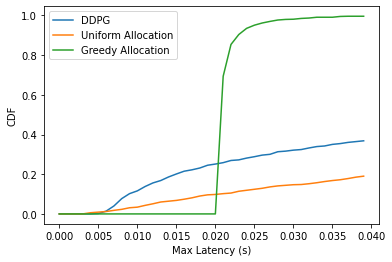

In [ ]:
stats22 = np.arange(0, 0.04, 0.001)
#stats22 = np.arange(5, 300, 5) #400
ep_cdf22 =np.zeros([1,len(stats22)])[0]
unif_cdf22 =np.zeros([1,len(stats22)])[0]
const_cdf22 =np.zeros([1,len(stats22)])[0]
count22 = 0
for il in stats22:
  tata22 = len(np.argwhere(ep_reward_list<il))
  tata222 = len(np.argwhere(unif_reward_list<il))
  tata223 = len(np.argwhere(const_reward_list<il))
  ep_cdf22[count22] = tata22/len(ep_reward_list)#999#1000
  unif_cdf22[count22] = tata222/len(unif_reward_list)#999#1000
  const_cdf22[count22] = tata223/len(const_reward_list)#999#1000
  count22 = count22 + 1

#plt.xlim(0, 70)
plt.plot(stats22,ep_cdf22)
plt.plot(stats22,unif_cdf22)
plt.plot(stats22,const_cdf22)
#plt.plot(stats22,dqn_cdf)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['DDPG', 'Uniform Allocation', 'Greedy Allocation','DQN'])
plt.show()

In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.002002
 0.01401401 0.04004004 0.07707708 0.1021021  0.11611612 0.13813814
 0.15615616 0.16816817 0.18618619 0.2012012  0.21521522 0.22222222
 0.23123123 0.24524525 0.25125125 0.25825826 0.26926927 0.27227227
 0.28128128 0.28828829 0.2962963  0.3003003  0.31331331 0.31631632
 0.32132132 0.32432432 0.33233233 0.33933934 0.34234234 0.35035035
 0.35435435 0.36036036 0.36436436 0.36836837]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.002002
 0.02702703 0.05305305 0.07107107 0.08408408 0.0950951  0.10710711
 0.12512513 0.13913914 0.15315315 0.16416416 0.17417417 0.18318318
 0.19019019 0.1961962  0.20820821 0.21621622 0.22622623 0.24224224
 0.25125125 0.25925926 0.26626627 0.26826827 0.27627628 0.28428428
 0.29229229 0.2972973  0.3043043  0.31031031 0.32032032 0.32332332
 0.32532533 0.32932933 0.33633634 0.34234234]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.002002   0.00700701
 0.02702703 0.03803804 0.05505506 0.06406406 0.07907908 0.09209209
 0.0990991  0.11411411 0.12612613 0.14014014 0.15315315 0.16416416
 0.17417417 0.18418418 0.19419419 0.20520521 0.21821822 0.22522523
 0.23823824 0.24324324 0.25325325 0.25925926 0.26626627 0.27227227
 0.27727728 0.27927928 0.28728729 0.28928929 0.2952953  0.3003003
 0.30730731 0.31131131 0.31631632 0.31931932]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.00600601 0.00900901
 0.01201201 0.01801802 0.02302302 0.03103103 0.03403403 0.04304304
 0.05105105 0.06006006 0.06406406 0.06806807 0.07407407 0.08108108
 0.09009009 0.0960961  0.0980981  0.1021021  0.10510511 0.11411411
 0.11911912 0.12412412 0.12912913 0.13613614 0.14114114 0.14414414
 0.14714715 0.14814815 0.15215215 0.15715716 0.16316316 0.16816817
 0.17217217 0.17817818 0.18518519 0.19019019]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.002002
 0.00500501 0.02202202 0.04604605 0.07307307 0.11211211 0.14614615
 0.18118118 0.20620621 0.21921922 0.23523524 0.25225225 0.25925926
 0.26826827 0.28128128 0.29329329 0.3033033  0.31531532 0.32432432
 0.33233233 0.33733734 0.34234234 0.34734735 0.35735736 0.36436436
 0.37537538 0.38038038 0.38438438 0.39339339 0.4004004  0.40940941
 0.41441441 0.41841842 0.42142142 0.43243243]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.002002
 0.00500501 0.02202202 0.04604605 0.07307307 0.11211211 0.14614615
 0.18118118 0.20620621 0.21921922 0.23523524 0.25225225 0.25925926
 0.26826827 0.28128128 0.29329329 0.3033033  0.31531532 0.32432432
 0.33233233 0.33733734 0.34234234 0.34734735 0.35735736 0.36436436
 0.37537538 0.38038038 0.38438438 0.39339339 0.4004004  0.40940941
 0.41441441 0.41841842 0.42142142 0.43243243]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.002002
 0.00500501 0.02202202 0.04604605 0.07307307 0.11211211 0.14614615
 0.18118118 0.20620621 0.21921922 0.23523524 0.25225225 0.25925926
 0.26826827 0.28128128 0.29329329 0.3033033  0.31531532 0.32432432
 0.33233233 0.33733734 0.34234234 0.34734735 0.35735736 0.36436436
 0.37537538 0.38038038 0.38438438 0.39339339 0.4004004  0.40940941
 0.41441441 0.41841842 0.42142142 0.43243243]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.001001
 0.01301301 0.03503504 0.06606607 0.08008008 0.0950951  0.10810811
 0.11911912 0.13613614 0.15215215 0.16216216 0.17017017 0.18418418
 0.1951952  0.2032032  0.21621622 0.22922923 0.24024024 0.24624625
 0.25325325 0.26426426 0.27327327 0.27627628 0.28328328 0.28628629
 0.2972973  0.3023023  0.30730731 0.31531532 0.32032032 0.32332332
 0.32732733 0.32932933 0.33433433 0.34234234]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.00600601 0.00900901
 0.01201201 0.01801802 0.02302302 0.03103103 0.03403403 0.04304304
 0.05105105 0.06006006 0.06406406 0.06806807 0.07407407 0.08108108
 0.09009009 0.0960961  0.0980981  0.1021021  0.10510511 0.11411411
 0.11911912 0.12412412 0.12912913 0.13613614 0.14114114 0.14414414
 0.14714715 0.14814815 0.15215215 0.15715716 0.16316316 0.16816817
 0.17217217 0.17817818 0.18518519 0.19019019]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.004004   0.03303303 0.07407407 0.11511512 0.14814815 0.17817818
 0.20520521 0.22122122 0.24024024 0.25125125 0.26326326 0.27727728
 0.28528529 0.3013013  0.31131131 0.32032032 0.32632633 0.33533534
 0.34334334 0.35235235 0.35735736 0.36136136 0.36936937 0.37637638
 0.38438438 0.39339339 0.3973974  0.3993994  0.40640641 0.40840841
 0.41041041 0.41341341 0.41941942 0.42742743]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.004004   0.03303303 0.07407407 0.11511512 0.14814815 0.17817818
 0.20520521 0.22122122 0.24024024 0.25125125 0.26326326 0.27727728
 0.28528529 0.3013013  0.31131131 0.32032032 0.32632633 0.33533534
 0.34334334 0.35235235 0.35735736 0.36136136 0.36936937 0.37637638
 0.38438438 0.39339339 0.3973974  0.3993994  0.40640641 0.40840841
 0.41041041 0.41341341 0.41941942 0.42742743]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.00600601 0.00900901
 0.01201201 0.01801802 0.02302302 0.03103103 0.03403403 0.04304304
 0.05105105 0.06006006 0.06406406 0.06806807 0.07407407 0.08108108
 0.09009009 0.0960961  0.0980981  0.1021021  0.10510511 0.11411411
 0.11911912 0.12412412 0.12912913 0.13613614 0.14114114 0.14414414
 0.14714715 0.14814815 0.15215215 0.15715716 0.16316316 0.16816817
 0.17217217 0.17817818 0.18518519 0.19019019]


In [ ]:
print(ep_cdf22) #critic 0.02

[0.         0.         0.         0.         0.001001   0.00900901
 0.01901902 0.03403403 0.04204204 0.05805806 0.07107107 0.07707708
 0.08808809 0.0980981  0.1041041  0.11911912 0.12612613 0.13513514
 0.14214214 0.14714715 0.15315315 0.16116116 0.17217217 0.17917918
 0.19119119 0.1981982  0.2022022  0.20620621 0.21721722 0.22622623
 0.23023023 0.23623624 0.24124124 0.25025025 0.26026026 0.26626627
 0.27227227 0.27527528 0.28128128 0.28528529]


In [ ]:
print(ep_cdf22) # critic 0.002

[0.         0.         0.         0.         0.002002   0.00700701
 0.01901902 0.03903904 0.05805806 0.08108108 0.0970971  0.10910911
 0.12512513 0.13513514 0.14114114 0.15015015 0.16816817 0.17517518
 0.18718719 0.1971972  0.2012012  0.20820821 0.21121121 0.22022022
 0.22622623 0.23423423 0.24324324 0.24824825 0.25825826 0.26526527
 0.27227227 0.27527528 0.28428428 0.29029029 0.2992993  0.30530531
 0.30930931 0.31231231 0.31931932 0.32532533]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.001001
 0.01001001 0.03403403 0.06406406 0.08208208 0.0990991  0.11011011
 0.12812813 0.13913914 0.15515516 0.16516517 0.17317317 0.18018018
 0.1961962  0.21021021 0.21821822 0.22322322 0.23123123 0.23623624
 0.24424424 0.25125125 0.25825826 0.26426426 0.26626627 0.27227227
 0.27727728 0.28528529 0.29229229 0.3003003  0.30830831 0.31531532
 0.31931932 0.32432432 0.32732733 0.33033033]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.01501502
 0.02902903 0.05205205 0.06406406 0.07307307 0.08708709 0.1031031
 0.11411411 0.13313313 0.14114114 0.15115115 0.16216216 0.17017017
 0.18018018 0.19319319 0.2012012  0.20820821 0.21121121 0.21521522
 0.22522523 0.22722723 0.23523524 0.24224224 0.24624625 0.25425425
 0.26426426 0.26726727 0.27227227 0.27827828 0.28728729 0.29329329
 0.2982983  0.3023023  0.30530531 0.30930931]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.01501502
 0.02902903 0.05205205 0.06406406 0.07307307 0.08708709 0.1031031
 0.11411411 0.13313313 0.14114114 0.15115115 0.16216216 0.17017017
 0.18018018 0.19319319 0.2012012  0.20820821 0.21121121 0.21521522
 0.22522523 0.22722723 0.23523524 0.24224224 0.24624625 0.25425425
 0.26426426 0.26726727 0.27227227 0.27827828 0.28728729 0.29329329
 0.2982983  0.3023023  0.30530531 0.30930931]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.004004   0.03303303 0.07407407 0.11511512 0.14814815 0.17817818
 0.20520521 0.22122122 0.24024024 0.25125125 0.26326326 0.27727728
 0.28528529 0.3013013  0.31131131 0.32032032 0.32632633 0.33533534
 0.34334334 0.35235235 0.35735736 0.36136136 0.36936937 0.37637638
 0.38438438 0.39339339 0.3973974  0.3993994  0.40640641 0.40840841
 0.41041041 0.41341341 0.41941942 0.42742743]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.00600601 0.00900901
 0.01201201 0.01801802 0.02302302 0.03103103 0.03403403 0.04304304
 0.05105105 0.06006006 0.06406406 0.06806807 0.07407407 0.08108108
 0.09009009 0.0960961  0.0980981  0.1021021  0.10510511 0.11411411
 0.11911912 0.12412412 0.12912913 0.13613614 0.14114114 0.14414414
 0.14714715 0.14814815 0.15215215 0.15715716 0.16316316 0.16816817
 0.17217217 0.17817818 0.18518519 0.19019019]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.00600601 0.00900901
 0.01201201 0.01801802 0.02302302 0.03103103 0.03403403 0.04304304
 0.05105105 0.06006006 0.06406406 0.06806807 0.07407407 0.08108108
 0.09009009 0.0960961  0.0980981  0.1021021  0.10510511 0.11411411
 0.11911912 0.12412412 0.12912913 0.13613614 0.14114114 0.14414414
 0.14714715 0.14814815 0.15215215 0.15715716 0.16316316 0.16816817
 0.17217217 0.17817818 0.18518519 0.19019019]


In [ ]:
print(ep_cdf22) #train for 600 ep

[0.         0.         0.         0.         0.001001   0.00900901
 0.01801802 0.03503504 0.04804805 0.05705706 0.07007007 0.07807808
 0.09209209 0.0970971  0.10710711 0.11711712 0.12912913 0.14014014
 0.14614615 0.15515516 0.16216216 0.16716717 0.17117117 0.17717718
 0.18618619 0.1951952  0.2042042  0.21021021 0.21221221 0.22422422
 0.23323323 0.23823824 0.24324324 0.25025025 0.25925926 0.26626627
 0.27027027 0.27627628 0.28028028 0.28528529]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.001001
 0.01001001 0.03403403 0.06406406 0.08208208 0.0990991  0.11011011
 0.12812813 0.13913914 0.15515516 0.16516517 0.17317317 0.18018018
 0.1961962  0.21021021 0.21821822 0.22322322 0.23123123 0.23623624
 0.24424424 0.25125125 0.25825826 0.26426426 0.26626627 0.27227227
 0.27727728 0.28528529 0.29229229 0.3003003  0.30830831 0.31531532
 0.31931932 0.32432432 0.32732733 0.33033033]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.001001
 0.01001001 0.03403403 0.06406406 0.08208208 0.0990991  0.11011011
 0.12812813 0.13913914 0.15515516 0.16516517 0.17317317 0.18018018
 0.1961962  0.21021021 0.21821822 0.22322322 0.23123123 0.23623624
 0.24424424 0.25125125 0.25825826 0.26426426 0.26626627 0.27227227
 0.27727728 0.28528529 0.29229229 0.3003003  0.30830831 0.31531532
 0.31931932 0.32432432 0.32732733 0.33033033]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.001001
 0.01001001 0.03403403 0.06406406 0.08208208 0.0990991  0.11011011
 0.12812813 0.13913914 0.15515516 0.16516517 0.17317317 0.18018018
 0.1961962  0.21021021 0.21821822 0.22322322 0.23123123 0.23623624
 0.24424424 0.25125125 0.25825826 0.26426426 0.26626627 0.27227227
 0.27727728 0.28528529 0.29229229 0.3003003  0.30830831 0.31531532
 0.31931932 0.32432432 0.32732733 0.33033033]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.002002   0.00700701
 0.01901902 0.03903904 0.05805806 0.08108108 0.0970971  0.10910911
 0.12512513 0.13513514 0.14114114 0.15015015 0.16816817 0.17517518
 0.18718719 0.1971972  0.2012012  0.20820821 0.21121121 0.22022022
 0.22622623 0.23423423 0.24324324 0.24824825 0.25825826 0.26526527
 0.27227227 0.27527528 0.28428428 0.29029029 0.2992993  0.30530531
 0.30930931 0.31231231 0.31931932 0.32532533]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.00800801 0.01301301
 0.02402402 0.03603604 0.04804805 0.05905906 0.06706707 0.07807808
 0.08508509 0.0950951  0.10710711 0.11711712 0.12112112 0.12712713
 0.13513514 0.14214214 0.14914915 0.15915916 0.16616617 0.18118118
 0.18918919 0.1991992  0.20620621 0.21021021 0.21721722 0.22022022
 0.22522523 0.23123123 0.24124124 0.24624625 0.25125125 0.25525526
 0.26026026 0.26826827 0.27027027 0.27527528]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.00800801 0.01301301
 0.02402402 0.03603604 0.04804805 0.05905906 0.06706707 0.07807808
 0.08508509 0.0950951  0.10710711 0.11711712 0.12112112 0.12712713
 0.13513514 0.14214214 0.14914915 0.15915916 0.16616617 0.18118118
 0.18918919 0.1991992  0.20620621 0.21021021 0.21721722 0.22022022
 0.22522523 0.23123123 0.24124124 0.24624625 0.25125125 0.25525526
 0.26026026 0.26826827 0.27027027 0.27527528]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.00600601 0.00900901
 0.01201201 0.01801802 0.02302302 0.03103103 0.03403403 0.04304304
 0.05105105 0.06006006 0.06406406 0.06806807 0.07407407 0.08108108
 0.09009009 0.0960961  0.0980981  0.1021021  0.10510511 0.11411411
 0.11911912 0.12412412 0.12912913 0.13613614 0.14114114 0.14414414
 0.14714715 0.14814815 0.15215215 0.15715716 0.16316316 0.16816817
 0.17217217 0.17817818 0.18518519 0.19019019]


In [ ]:
#again
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.01201201 0.04404404 0.18118118 0.23923924 0.28328328 0.32332332
 0.35435435 0.39239239 0.42042042 0.43943944 0.46046046 0.47547548
 0.49049049 0.5005005  0.51251251 0.52552553 0.54454454 0.55255255
 0.56856857 0.57757758 0.58158158 0.5975976  0.60860861 0.61061061
 0.61561562 0.61961962 0.62262262 0.63163163 0.63663664 0.64364364
 0.65265265 0.66166166 0.66366366 0.66666667 0.67167167 0.67467467
 0.67867868 0.68068068 0.68268268 0.68668669 0.69169169 0.6966967
 0.7007007  0.70670671 0.71071071 0.71171171 0.71471471 0.71771772
 0.72072072 0.72172172 0.72672673 0.72772773 0.73173173]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.02302302 0.06006006 0.09009009
 0.11411411 0.14114114 0.15715716 0.18518519 0.2002002  0.22022022
 0.24624625 0.25625626 0.28028028 0.2962963  0.30830831 0.32732733
 0.33933934 0.35335335 0.36736737 0.37737738 0.39039039 0.4024024
 0.40640641 0.41441441 0.42042042 0.42642643 0.43443443 0.44044044
 0.45745746 0.46346346 0.47247247 0.47847848 0.48748749 0.49349349
 0.5015015  0.50550551 0.51851852 0.52552553 0.53053053 0.53153153
 0.53253253 0.53553554 0.54754755 0.54954955 0.55355355 0.55555556
 0.56056056 0.56856857 0.57057057 0.57557558 0.57857858 0.57857858
 0.58258258 0.58758759 0.59359359 0.5995996  0.6046046 ]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.01201201 0.04404404 0.18118118 0.23923924 0.28328328 0.32332332
 0.35435435 0.39239239 0.42042042 0.43943944 0.46046046 0.47547548
 0.49049049 0.5005005  0.51251251 0.52552553 0.54454454 0.55255255
 0.56856857 0.57757758 0.58158158 0.5975976  0.60860861 0.61061061
 0.61561562 0.61961962 0.62262262 0.63163163 0.63663664 0.64364364
 0.65265265 0.66166166 0.66366366 0.66666667 0.67167167 0.67467467
 0.67867868 0.68068068 0.68268268 0.68668669 0.69169169 0.6966967
 0.7007007  0.70670671 0.71071071 0.71171171 0.71471471 0.71771772
 0.72072072 0.72172172 0.72672673 0.72772773 0.73173173]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.02302302 0.06006006 0.09009009
 0.11411411 0.14114114 0.15715716 0.18518519 0.2002002  0.22022022
 0.24624625 0.25625626 0.28028028 0.2962963  0.30830831 0.32732733
 0.33933934 0.35335335 0.36736737 0.37737738 0.39039039 0.4024024
 0.40640641 0.41441441 0.42042042 0.42642643 0.43443443 0.44044044
 0.45745746 0.46346346 0.47247247 0.47847848 0.48748749 0.49349349
 0.5015015  0.50550551 0.51851852 0.52552553 0.53053053 0.53153153
 0.53253253 0.53553554 0.54754755 0.54954955 0.55355355 0.55555556
 0.56056056 0.56856857 0.57057057 0.57557558 0.57857858 0.57857858
 0.58258258 0.58758759 0.59359359 0.5995996  0.6046046 ]


In [ ]:
# 10 AP  3 UE shadow fading
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.002002   0.22522523 0.38938939 0.46346346 0.53153153
 0.58958959 0.63363363 0.66966967 0.7047047  0.72772773 0.74874875
 0.76776777 0.78178178 0.7957958  0.81081081 0.81981982 0.83183183
 0.84384384 0.84984985 0.85485485 0.86186186 0.86886887 0.87487487
 0.87887888 0.88188188 0.88588589 0.88888889 0.89289289 0.89489489
 0.8988989  0.9009009  0.9049049  0.90890891 0.91191191 0.91491491
 0.91991992 0.91991992 0.92292292 0.92292292 0.92592593 0.92992993
 0.93093093 0.93393393 0.93593594 0.93793794 0.93993994 0.93993994
 0.94494494 0.94594595 0.94694695 0.94794795 0.94794795]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.03703704 0.10910911
 0.16116116 0.23123123 0.27727728 0.31631632 0.35835836 0.3983984
 0.42942943 0.46846847 0.48948949 0.52052052 0.54954955 0.57957958
 0.59459459 0.61361361 0.62062062 0.63663664 0.64864865 0.66266266
 0.67367367 0.69169169 0.6966967  0.70970971 0.71671672 0.72872873
 0.73473473 0.74074074 0.74574575 0.75775776 0.76176176 0.76976977
 0.77977978 0.78578579 0.79479479 0.7997998  0.80580581 0.81181181
 0.81881882 0.81881882 0.82482482 0.82682683 0.82782783 0.83083083
 0.83483483 0.84284284 0.84484484 0.84684685 0.84884885 0.85285285
 0.85685686 0.85785786 0.86086086 0.86186186 0.86386386]


In [ ]:
#########################

In [ ]:
#baseline 7
'''
critic_lr = 0.02  #0.02 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.1 #0.001 - 2 users  0.0001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr) #adam
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)  #adam

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 128) #200, 128 - 2
'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.48848849 0.54954955 0.56856857 0.59259259
 0.61061061 0.62362362 0.63663664 0.64564565 0.66066066 0.67167167
 0.69369369 0.70570571 0.71571572 0.72372372 0.73573574 0.74174174
 0.74874875 0.75375375 0.76076076 0.76976977 0.77877878 0.78378378
 0.79079079 0.7957958  0.8018018  0.80780781 0.80980981 0.81781782
 0.82282282 0.82782783 0.83383383 0.83383383 0.83683684 0.84084084
 0.84684685 0.84884885 0.85085085 0.85085085 0.85385385 0.85685686
 0.86186186 0.86386386 0.86486486 0.86686687 0.86886887]


In [ ]:
#baseline 6 shad 
'''
critic_lr = 0.02  #0.02 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.01 #0.001 - 2 users  0.0001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr) #adam
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)  #adam

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 128) #200, 128 - 2
'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00600601 0.05705706 0.15415415
 0.28228228 0.38538539 0.46246246 0.52252252 0.58758759 0.64864865
 0.6996997  0.72972973 0.75875876 0.78178178 0.7997998  0.81581582
 0.82682683 0.83983984 0.84784785 0.86186186 0.87187187 0.87987988
 0.88588589 0.89189189 0.8988989  0.9009009  0.9029029  0.9049049
 0.90990991 0.91391391 0.91891892 0.91991992 0.92292292 0.92492492
 0.92692693 0.92992993 0.93093093 0.93393393 0.93793794 0.93893894
 0.93993994 0.93993994 0.94094094 0.94394394 0.94694695 0.94694695
 0.94694695 0.94694695 0.94894895 0.94994995 0.95095095]


In [ ]:
ep_6 = [0.  ,       0. ,        0.,         0. ,        0.,         0.,
 0.       ,  0.        , 0.       ,  0.00600601, 0.05705706, 0.15415415,
 0.28228228, 0.38538539, 0.46246246, 0.52252252, 0.58758759, 0.64864865,
 0.6996997 , 0.72972973, 0.75875876, 0.78178178, 0.7997998 , 0.81581582,
 0.82682683, 0.83983984, 0.84784785, 0.86186186, 0.87187187, 0.87987988,
 0.88588589, 0.89189189, 0.8988989 , 0.9009009 , 0.9029029 , 0.9049049,
 0.90990991, 0.91391391, 0.91891892, 0.91991992, 0.92292292, 0.92492492,
 0.92692693, 0.92992993, 0.93093093, 0.93393393, 0.93793794, 0.93893894,
 0.93993994, 0.93993994, 0.94094094, 0.94394394, 0.94694695, 0.94694695,
 0.94694695, 0.94694695, 0.94894895, 0.94994995, 0.95095095]

In [ ]:
#baseline 5 shad
'''
critic_lr = 0.02  #0.02 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.01 #0.001 - 2 users  0.0001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr) #adam
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)  #adam

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 32) #200, 128 - 2
'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.004004   0.07007007 0.22922923 0.34434434
 0.42942943 0.5005005  0.54554555 0.5965966  0.63263263 0.66966967
 0.70570571 0.73573574 0.75475475 0.76476476 0.77677678 0.79279279
 0.81081081 0.81981982 0.82582583 0.82982983 0.83383383 0.84084084
 0.84284284 0.84584585 0.85385385 0.85785786 0.86186186 0.86586587
 0.86886887 0.87287287 0.87687688 0.87887888 0.88188188 0.88488488
 0.88588589 0.88688689 0.88888889 0.89089089 0.89489489 0.89489489
 0.8958959  0.8978979  0.9029029  0.90690691 0.91191191 0.91291291
 0.91391391 0.91491491 0.91591592 0.91691692 0.91791792]


In [ ]:
ep_5 = [0. ,        0. ,        0. ,        0. ,        0. ,        0.,
 0.       ,  0.        , 0.004004 ,  0.07007007, 0.22922923, 0.34434434,
 0.42942943, 0.5005005 , 0.54554555, 0.5965966 , 0.63263263, 0.66966967,
 0.70570571, 0.73573574, 0.75475475, 0.76476476, 0.77677678, 0.79279279,
 0.81081081, 0.81981982, 0.82582583, 0.82982983, 0.83383383, 0.84084084,
 0.84284284, 0.84584585, 0.85385385, 0.85785786, 0.86186186, 0.86586587,
 0.86886887, 0.87287287, 0.87687688, 0.87887888, 0.88188188, 0.88488488,
 0.88588589, 0.88688689, 0.88888889, 0.89089089, 0.89489489, 0.89489489,
 0.8958959 , 0.8978979 , 0.9029029 , 0.90690691, 0.91191191, 0.91291291,
 0.91391391, 0.91491491, 0.91591592, 0.91691692, 0.91791792]

In [ ]:
#baseline4 shad
'''
critic_lr = 0.02  #0.2 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.001 #0.001 - 2 users  0.0001

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 64) #200, 32 

'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.01101101 0.07607608 0.16816817 0.25625626
 0.32632633 0.4014014  0.45445445 0.51751752 0.55155155 0.58058058
 0.5955956  0.61361361 0.63663664 0.65465465 0.67067067 0.67967968
 0.69169169 0.7017017  0.71171171 0.71871872 0.72172172 0.72272272
 0.73073073 0.73473473 0.74374374 0.74974975 0.75475475 0.76176176
 0.76476476 0.77277277 0.77877878 0.78378378 0.78578579 0.79179179
 0.79279279 0.8008008  0.8028028  0.8038038  0.80580581 0.81281281
 0.81381381 0.81581582 0.81981982 0.82382382 0.82482482 0.82782783
 0.82782783 0.82982983 0.83483483 0.83583584 0.83583584]


In [ ]:
ep_4 = [0.,         0. ,        0. ,        0. ,        0. ,        0.,
 0.       ,  0.        , 0.01101101, 0.07607608, 0.16816817, 0.25625626,
 0.32632633, 0.4014014 , 0.45445445, 0.51751752, 0.55155155, 0.58058058,
 0.5955956 , 0.61361361, 0.63663664, 0.65465465, 0.67067067, 0.67967968,
 0.69169169, 0.7017017 , 0.71171171, 0.71871872, 0.72172172, 0.72272272,
 0.73073073, 0.73473473, 0.74374374, 0.74974975, 0.75475475, 0.76176176,
 0.76476476, 0.77277277, 0.77877878, 0.78378378, 0.78578579, 0.79179179,
 0.79279279, 0.8008008 , 0.8028028 , 0.8038038 , 0.80580581, 0.81281281,
 0.81381381, 0.81581582, 0.81981982, 0.82382382, 0.82482482, 0.82782783,
 0.82782783, 0.82982983, 0.83483483, 0.83583584, 0.83583584]

In [ ]:
#baseline3 shad
'''
critic_lr = 0.02  #0.2 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.001 #0.001 - 2 users  0.0001

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 32) #200, 32 

'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.002002   0.22522523 0.38938939 0.46346346 0.53153153
 0.58958959 0.63363363 0.66966967 0.7047047  0.72772773 0.74874875
 0.76776777 0.78178178 0.7957958  0.81081081 0.81981982 0.83183183
 0.84384384 0.84984985 0.85485485 0.86186186 0.86886887 0.87487487
 0.87887888 0.88188188 0.88588589 0.88888889 0.89289289 0.89489489
 0.8988989  0.9009009  0.9049049  0.90890891 0.91191191 0.91491491
 0.91991992 0.91991992 0.92292292 0.92292292 0.92592593 0.92992993
 0.93093093 0.93393393 0.93593594 0.93793794 0.93993994 0.93993994
 0.94494494 0.94594595 0.94694695 0.94794795 0.94794795]


In [ ]:
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.002002   0.22522523 0.38938939 0.46346346 0.53153153
 0.58958959 0.63363363 0.66966967 0.7047047  0.72772773 0.74874875
 0.76776777 0.78178178 0.7957958  0.81081081 0.81981982 0.83183183
 0.84384384 0.84984985 0.85485485 0.86186186 0.86886887 0.87487487
 0.87887888 0.88188188 0.88588589 0.88888889 0.89289289 0.89489489
 0.8988989  0.9009009  0.9049049  0.90890891 0.91191191 0.91491491
 0.91991992 0.91991992 0.92292292 0.92292292 0.92592593 0.92992993
 0.93093093 0.93393393 0.93593594 0.93793794 0.93993994 0.93993994
 0.94494494 0.94594595 0.94694695 0.94794795 0.94794795]


In [ ]:
ep_3 = [0.  ,       0. ,        0.  ,       0. ,        0.  ,       0.,
 0.       ,  0.002002  , 0.22522523, 0.38938939, 0.46346346, 0.53153153,
 0.58958959, 0.63363363, 0.66966967, 0.7047047 , 0.72772773, 0.74874875,
 0.76776777, 0.78178178, 0.7957958 , 0.81081081, 0.81981982, 0.83183183,
 0.84384384, 0.84984985, 0.85485485, 0.86186186, 0.86886887, 0.87487487,
 0.87887888, 0.88188188, 0.88588589, 0.88888889, 0.89289289, 0.89489489,
 0.8988989 , 0.9009009 , 0.9049049 , 0.90890891, 0.91191191, 0.91491491,
 0.91991992, 0.91991992, 0.92292292, 0.92292292, 0.92592593, 0.92992993,
 0.93093093, 0.93393393, 0.93593594, 0.93793794, 0.93993994, 0.93993994,
 0.94494494, 0.94594595, 0.94694695, 0.94794795, 0.94794795]

In [ ]:
#baseline2 shad
'''
critic_lr = 0.2  #0.2 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.001 #0.001 - 2 users  0.0001

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 128) #200, 128 
'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.001001   0.02002002 0.06606607 0.12412412
 0.1981982  0.27527528 0.41541542 0.54154154 0.59459459 0.63363363
 0.66966967 0.6976977  0.71671672 0.72672673 0.74474474 0.75875876
 0.77877878 0.78778779 0.79479479 0.8018018  0.80880881 0.81581582
 0.82282282 0.83283283 0.83483483 0.84184184 0.84584585 0.84884885
 0.85185185 0.85485485 0.85585586 0.85885886 0.86886887 0.87287287
 0.87387387 0.87487487 0.87687688 0.87887888 0.87887888 0.88188188
 0.88488488 0.88688689 0.88888889 0.88888889 0.88988989 0.89289289
 0.89389389 0.89489489 0.8978979  0.9009009  0.9029029 ]


In [ ]:
ep_2 = [0. ,        0. ,        0.,         0. ,        0. ,        0.,
 0.        , 0.        , 0.001001 ,  0.02002002, 0.06606607, 0.12412412,
 0.1981982 , 0.27527528, 0.41541542, 0.54154154, 0.59459459, 0.63363363,
 0.66966967, 0.6976977 , 0.71671672, 0.72672673, 0.74474474, 0.75875876,
 0.77877878, 0.78778779, 0.79479479, 0.8018018 , 0.80880881, 0.81581582,
 0.82282282, 0.83283283, 0.83483483, 0.84184184, 0.84584585, 0.84884885,
 0.85185185, 0.85485485, 0.85585586, 0.85885886, 0.86886887, 0.87287287,
 0.87387387, 0.87487487, 0.87687688, 0.87887888, 0.87887888, 0.88188188,
 0.88488488, 0.88688689, 0.88888889, 0.88888889, 0.88988989, 0.89289289,
 0.89389389, 0.89489489, 0.8978979 , 0.9009009 , 0.9029029 ]

In [ ]:
#baseline1 shad
'''
critic_lr = 0.02  #0.2 was working
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.001 #0.001 - 2 users  0.0001

total_episodes = 300 #600 100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.001 #0.001

buffer = Buffer(200, 128) #200, 128 
'''
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00600601 0.06806807
 0.26126126 0.43843844 0.52252252 0.57157157 0.6016016  0.63063063
 0.65765766 0.67567568 0.68768769 0.70870871 0.72072072 0.73173173
 0.74074074 0.74774775 0.75375375 0.76076076 0.76476476 0.77577578
 0.78178178 0.79079079 0.79479479 0.8028028  0.81481481 0.82182182
 0.82482482 0.82782783 0.83183183 0.83983984 0.83983984 0.84384384
 0.84584585 0.84684685 0.84684685 0.84784785 0.84984985 0.85285285
 0.85585586 0.85685686 0.85885886 0.85985986 0.86386386 0.86486486
 0.86786787 0.86886887 0.86986987 0.87287287 0.87587588]


In [ ]:
ep_base = [0.   ,      0. ,        0.   ,      0.  ,       0. ,        0.,
 0.       ,  0.        , 0.        , 0.         ,0.00600601, 0.06806807,
 0.26126126, 0.43843844, 0.52252252, 0.57157157 ,0.6016016 , 0.63063063,
 0.65765766, 0.67567568, 0.68768769, 0.70870871 ,0.72072072, 0.73173173,
 0.74074074, 0.74774775, 0.75375375, 0.76076076 ,0.76476476, 0.77577578,
 0.78178178, 0.79079079, 0.79479479, 0.8028028  ,0.81481481, 0.82182182,
 0.82482482, 0.82782783, 0.83183183, 0.83983984 ,0.83983984, 0.84384384,
 0.84584585, 0.84684685, 0.84684685, 0.84784785 ,0.84984985, 0.85285285,
 0.85585586, 0.85685686, 0.85885886, 0.85985986 ,0.86386386, 0.86486486,
 0.86786787, 0.86886887, 0.86986987, 0.87287287 ,0.87587588]

"\nplt.legend(['Critic LR = 0.02, Actor LR = 0.1, Gamma = 0.7, Tau = 0.001, Batch Size =128',...\n            'Critic LR = 0.02, Actor LR = 0.01, Gamma = 0.7, Tau = 0.001, Batch Size =128',...\n            'Critic LR = 0.02, Actor LR = 0.01, Gamma = 0.7, Tau = 0.001, Batch Size =32',...\n            'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =64',...\n            'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =32',...\n            'Critic LR = 0.2, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =128',...\n            'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =128'])\n"

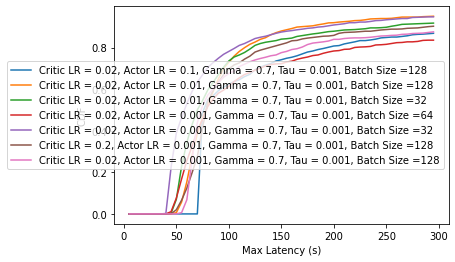

In [ ]:
plt.plot(stats22,ep_cdf22)
plt.plot(stats22,ep_6)
plt.plot(stats22,ep_5)
plt.plot(stats22,ep_4)
plt.plot(stats22,ep_3)
plt.plot(stats22,ep_2)
plt.plot(stats22,ep_base)

plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['Critic LR = 0.02, Actor LR = 0.1, Gamma = 0.7, Tau = 0.001, Batch Size =128', 'Critic LR = 0.02, Actor LR = 0.01, Gamma = 0.7, Tau = 0.001, Batch Size =128', 'Critic LR = 0.02, Actor LR = 0.01, Gamma = 0.7, Tau = 0.001, Batch Size =32', 'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =64', 'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =32',  'Critic LR = 0.2, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =128', 'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =128'])

'''
plt.legend(['Critic LR = 0.02, Actor LR = 0.1, Gamma = 0.7, Tau = 0.001, Batch Size =128',...
            'Critic LR = 0.02, Actor LR = 0.01, Gamma = 0.7, Tau = 0.001, Batch Size =128',...
            'Critic LR = 0.02, Actor LR = 0.01, Gamma = 0.7, Tau = 0.001, Batch Size =32',...
            'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =64',...
            'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =32',...
            'Critic LR = 0.2, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =128',...
            'Critic LR = 0.02, Actor LR = 0.001, Gamma = 0.7, Tau = 0.001, Batch Size =128'])
'''

In [ ]:
###############################################################

In [ ]:
#9_13_2022 25 APs
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.001001   0.002002   0.00500501 0.01401401 0.01901902 0.02402402
 0.03103103 0.04104104 0.04604605 0.05405405 0.06006006 0.06906907
 0.07307307 0.07707708 0.08408408 0.09109109 0.0950951  0.10510511
 0.11411411 0.11811812 0.11911912 0.12312312 0.13013013 0.13013013
 0.13513514 0.14014014 0.14614615 0.15315315 0.15615616 0.15915916
 0.16316316 0.16616617 0.17117117 0.17317317 0.17817818 0.18618619
 0.18918919 0.1951952  0.1991992  0.20620621 0.20820821 0.21021021
 0.21421421 0.21721722 0.22122122 0.22522523 0.23223223 0.23623624
 0.24224224 0.24524525 0.25425425 0.25925926 0.26426426]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.003003
 0.003003   0.00500501 0.00800801 0.00800801 0.01001001 0.01601602
 0.01801802 0.02302302 0.02902903 0.03703704 0.04204204 0.04804805
 0.05205205 0.06106106 0.07207207 0.07707708 0.08508509 0.09109109
 0.09409409 0.1001001  0.10910911 0.11611612 0.12012012 0.12712713
 0.13713714 0.14314314 0.14814815 0.15615616 0.17217217 0.18218218
 0.18618619 0.1961962  0.20820821 0.21221221 0.22622623 0.23323323
 0.23823824 0.25125125 0.25925926 0.26826827 0.27527528 0.28128128
 0.29229229 0.29329329 0.3003003  0.3043043  0.31231231]


In [ ]:
print(const_cdf22)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
#9_13_2022 5 APs
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04604605 0.14514515 0.25025025 0.32932933
 0.41641642 0.5045045  0.67067067 0.73473473 0.76976977 0.79079079
 0.81281281 0.83583584 0.84584585 0.87187187 0.91491491 0.97397397
 0.98498498 0.98698699 0.98698699 0.98698699 0.98798799 0.98798799
 0.98798799 0.98798799 0.98898899 0.98898899 0.98898899 0.98898899
 0.98998999 0.98998999 0.98998999 0.98998999 0.99099099 0.99099099
 0.99099099 0.99199199 0.99299299 0.99299299 0.99299299 0.99299299
 0.99299299 0.99299299 0.99299299 0.99299299 0.99299299]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.51851852 0.88988989 0.96196196 0.98598599
 0.99199199 0.99299299 0.99399399 0.996997   0.998999   0.998999
 0.998999   0.998999   0.998999   1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [ ]:
print(const_cdf22)

[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.997998 0.998999 1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.      ]


In [ ]:
#9_13_2022 10 APs
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.004004   0.38838839 0.71571572 0.81581582
 0.86086086 0.88788789 0.91391391 0.92292292 0.94294294 0.95795796
 0.97197197 0.97497497 0.97997998 0.98298298 0.98598599 0.98998999
 0.99099099 0.99199199 0.99199199 0.99299299 0.99299299 0.99399399
 0.99399399 0.99399399 0.99499499 0.99499499 0.99499499 0.99499499
 0.99499499 0.99499499 0.99499499 0.99499499 0.99499499 0.99499499
 0.995996   0.995996   0.995996   0.995996   0.995996   0.995996
 0.995996   0.995996   0.995996   0.995996   0.995996   0.995996
 0.995996   0.995996   0.995996   0.995996   0.995996  ]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.         0.13513514
 0.40840841 0.61661662 0.73473473 0.81981982 0.87487487 0.91291291
 0.93193193 0.94894895 0.95895896 0.96496496 0.97097097 0.97797798
 0.98198198 0.98298298 0.98698699 0.98998999 0.99099099 0.99299299
 0.995996   0.997998   0.997998   0.997998   0.998999   0.998999
 0.998999   0.998999   0.998999   0.998999   1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [ ]:
print(const_cdf22)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
#9_13_2022 20 APs
print(ep_cdf22)

[0.         0.         0.         0.         0.         0.03103103
 0.1011011  0.18118118 0.26026026 0.32332332 0.37537538 0.41641642
 0.46246246 0.5025025  0.52452452 0.55055055 0.56656657 0.58458458
 0.60660661 0.62262262 0.63863864 0.65065065 0.66566567 0.67667668
 0.68868869 0.7027027  0.70970971 0.71871872 0.73073073 0.73773774
 0.74674675 0.75475475 0.75675676 0.76276276 0.76676677 0.77077077
 0.77477477 0.78178178 0.78978979 0.79079079 0.7957958  0.8018018
 0.80680681 0.80880881 0.81281281 0.81681682 0.81781782 0.81981982
 0.82382382 0.82582583 0.82882883 0.83183183 0.83283283 0.83583584
 0.83783784 0.83983984 0.84084084 0.84284284 0.84584585]


In [ ]:
print(unif_cdf22)

[0.         0.         0.         0.         0.         0.
 0.002002   0.00900901 0.01901902 0.03303303 0.05805806 0.07907908
 0.1021021  0.13013013 0.14914915 0.16116116 0.17717718 0.1971972
 0.21321321 0.23823824 0.25425425 0.27427427 0.28928929 0.3043043
 0.31731732 0.32932933 0.34234234 0.36036036 0.37337337 0.38438438
 0.39439439 0.4014014  0.41341341 0.41841842 0.43043043 0.44144144
 0.45345345 0.46446446 0.47447447 0.47847848 0.48548549 0.4974975
 0.5045045  0.51051051 0.52352352 0.52752753 0.53653654 0.54654655
 0.55055055 0.55855856 0.56956957 0.57757758 0.58258258 0.58958959
 0.59459459 0.6016016  0.60660661 0.60860861 0.61361361]


In [ ]:
print(const_cdf22)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
print(ep_cdf22) #20 APs 0.02 - critic
print(critic_lr)

[0.         0.         0.         0.         0.         0.
 0.02202202 0.08008008 0.14214214 0.19319319 0.23823824 0.27027027
 0.30530531 0.32932933 0.35335335 0.38038038 0.4034034  0.42742743
 0.45045045 0.46246246 0.48048048 0.49249249 0.5005005  0.51251251
 0.52652653 0.53953954 0.54854855 0.55255255 0.56456456 0.57557558
 0.58458458 0.59459459 0.6036036  0.61361361 0.61861862 0.62662663
 0.63063063 0.63563564 0.64264264 0.64864865 0.65565566 0.66466466
 0.66666667 0.67767768 0.68168168 0.68568569 0.68868869 0.68968969
 0.69469469 0.7007007  0.7037037  0.70770771 0.71071071 0.71571572
 0.71971972 0.72472472 0.73073073 0.73173173 0.73673674]
0.02


In [ ]:
print(ep_cdf22) #20 APs

[0.         0.         0.         0.         0.         0.
 0.00700701 0.03503504 0.10610611 0.16216216 0.20820821 0.24624625
 0.28128128 0.31131131 0.34334334 0.36536537 0.38038038 0.3983984
 0.41341341 0.42942943 0.44944945 0.46246246 0.47447447 0.48448448
 0.49149149 0.5015015  0.50950951 0.51851852 0.52952953 0.53953954
 0.54554555 0.55355355 0.56056056 0.56756757 0.57557558 0.58758759
 0.59359359 0.6006006  0.61361361 0.61961962 0.62862863 0.63863864
 0.64164164 0.65065065 0.66366366 0.67067067 0.67567568 0.68468468
 0.69369369 0.6966967  0.6996997  0.7027027  0.71071071 0.71271271
 0.71371371 0.71871872 0.71971972 0.72472472 0.72472472]


In [ ]:
print(ep_cdf22)  #15 APs

[0.         0.         0.         0.         0.         0.
 0.001001   0.01201201 0.08008008 0.20620621 0.33333333 0.38338338
 0.42042042 0.44444444 0.48148148 0.50550551 0.53353353 0.54954955
 0.56056056 0.57857858 0.5965966  0.61461461 0.62462462 0.63763764
 0.64864865 0.65565566 0.66566567 0.67167167 0.67967968 0.68568569
 0.6956957  0.7017017  0.71071071 0.71271271 0.71971972 0.72572573
 0.73273273 0.73573574 0.74474474 0.75175175 0.75675676 0.76176176
 0.76576577 0.77177177 0.77477477 0.77877878 0.78278278 0.79179179
 0.79479479 0.7977978  0.8008008  0.80580581 0.80580581 0.80680681
 0.80880881 0.80880881 0.80980981 0.81081081 0.81381381]


In [ ]:
stats = np.arange(5, 8000000, 5) #3000 #10000000
#stats = np.arange(100, 3000, 100)
ep_cdf =np.zeros([1,len(stats)])[0]
unif_cdf =np.zeros([1,len(stats)])[0]
const_cdf =np.zeros([1,len(stats)])[0]
count = 0
for il in stats:
  tata = len(np.argwhere(ep_reward_list<il))
  tata2 = len(np.argwhere(unif_reward_list<il))
  tata3 = len(np.argwhere(const_reward_list<il))
  ep_cdf[count] = tata/len(ep_reward_list)#999#1000
  unif_cdf[count] = tata2/len(unif_reward_list)#999#1000
  const_cdf[count] = tata3/len(const_reward_list)#999#1000
  count = count + 1

plt.xlim(0, 70)
plt.plot(ep_cdf)
plt.plot(unif_cdf)
plt.plot(const_cdf)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()

KeyboardInterrupt: ignored

In [ ]:
print(len(ep_reward_list))
print(len(testlines))
print(len(const_reward_list))
print(indexxx)
print(actor_lr)
#print(xx1)
#print(xx2)
#print(ep_reward_list)

999
2000
999
2000
0.001


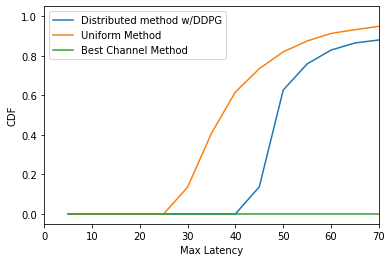

In [ ]:
#stats = np.arange(10, 8000000, 10) #3000 #10000000
stats = np.arange(5, 500, 5)
ep_cdf =np.zeros([1,len(stats)])[0]
unif_cdf =np.zeros([1,len(stats)])[0]
const_cdf =np.zeros([1,len(stats)])[0]
count = 0
for il in stats:
  tata = len(np.argwhere(ep_reward_list<il))
  tata2 = len(np.argwhere(unif_reward_list<il))
  tata3 = len(np.argwhere(const_reward_list<il))
  '''
  ep_cdf[count] = tata/999#1000
  unif_cdf[count] = tata2/999#1000
  const_cdf[count] = tata3/999#1000
  '''
  ep_cdf[count] = tata/(len(ep_reward_list))#999#1000
  unif_cdf[count] = tata2/(len(unif_reward_list))#999#1000
  const_cdf[count] = tata3/(len(const_reward_list))#999#1000
  count = count + 1

plt.xlim(0, 70)
plt.plot(stats,ep_cdf)
plt.plot(stats,unif_cdf)
plt.plot(stats,const_cdf)
plt.xlabel("Max Latency")
plt.ylabel("CDF")
plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()

In [ ]:
#cdf ver 2

print(len(ep_cdf))
print(len(stats))
'''
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

N = len(ep_reward_list)
data = ep_reward_list #np.random.randn(N)
count, bins_count = np.histogram(data, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()
'''

'''
sorted_ddpg = np.sort(ep_reward_list)
sorted_const = np.sort(const_reward_list)
sorted_unif = np.sort(unif_reward_list)
p = 1. * np.arange(len(sorted_ddpg)) / float(len(sorted_ddpg) - 1)
p_const = 1. * np.arange(len(sorted_const)) / float(len(sorted_const) - 1)
p_unif = 1. * np.arange(len(sorted_unif)) / float(len(sorted_unif) - 1)


figure, axis = plt.subplots(2, 2)
  

plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)
plot3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2)

plot2.plot(sorted_ddpg, p)
plot2.set_title('DDPG')
  
# Plot for exponent
plot1.plot(sorted_const, p_const)
plot1.set_title('Best Channel')
  
# Plot for Square
plot3.plot(sorted_unif, p_unif)
plot3.set_title('Uniform')
  
# Packing all the plots and displaying them
plt.tight_layout()
plt.show()



#plt.plot(p_const)
#plt.xlabel("Max Latency")
#plt.ylabel("CDF")
#plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()
'''

99
99


'\nsorted_ddpg = np.sort(ep_reward_list)\nsorted_const = np.sort(const_reward_list)\nsorted_unif = np.sort(unif_reward_list)\np = 1. * np.arange(len(sorted_ddpg)) / float(len(sorted_ddpg) - 1)\np_const = 1. * np.arange(len(sorted_const)) / float(len(sorted_const) - 1)\np_unif = 1. * np.arange(len(sorted_unif)) / float(len(sorted_unif) - 1)\n\n\nfigure, axis = plt.subplots(2, 2)\n  \n\nplot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)\nplot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)\nplot3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2)\n\nplot2.plot(sorted_ddpg, p)\nplot2.set_title(\'DDPG\')\n  \n# Plot for exponent\nplot1.plot(sorted_const, p_const)\nplot1.set_title(\'Best Channel\')\n  \n# Plot for Square\nplot3.plot(sorted_unif, p_unif)\nplot3.set_title(\'Uniform\')\n  \n# Packing all the plots and displaying them\nplt.tight_layout()\nplt.show()\n\n\n\n#plt.plot(p_const)\n#plt.xlabel("Max Latency")\n#plt.ylabel("CDF")\n#plt.legend([\'Distributed method w/DDPG\', \'Uni

In [ ]:
print(new_rate)
'''
print(rate[0])
x = rate[0][:]
print(x)
x[6] = 0
print(x)
'''
#print(rate[0])
#print(sum_temp)
#print(sum_den)

'''
print('alphasss_indices')
print(alphasss_indices)
print('Alphas')
print(alphasss)
print('Original rate')
print(rate)
print('New_rate')
print(new_rate)
print('New alphasss')
print(new_alphasss)
'''

####print(actions[0])
###print(actions[1])
#print(sum_temp)
#print(rate[0])
#print(new_rate)
#print(alphasss)
###########print(B*np.log2(1+((sum_temp[0])/(1+sum_den[0]))))

'''
x = B*np.log2(1+((sum_temp[0])/(1+sum_den[0])))
print('rate')
print(x)
print(type(x))
y = x.copy()
print('copy rate')
print(y)
print('new y')
y[6] = 1
print(y)
print('Original x')
print(x)
'''


#print(np.where(actions[0]==0)[0])
#print(np.where(actions[1]==0)[0])
#print(np.where(rate[0]==0)[0])

'''
print(actions[sew])
print(len(product))
print(new_rate)
print(rate[0])
print(new_alphasss)
'''

[]


'\nprint(actions[sew])\nprint(len(product))\nprint(new_rate)\nprint(rate[0])\nprint(new_alphasss)\n'